In [11]:
# Traitement de données
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics

# Scikit-learn : Prétraitement, modèles, métriques, etc.
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    RepeatedStratifiedKFold, validation_curve, learning_curve
)
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, roc_auc_score, roc_curve
)

# Modèles classiquesy
# XGBoost
from xgboost import XGBClassifier

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Deep Learning (si tu l'utilises)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Autres
import os, ast, pickle, warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_score
from sklearn.metrics import precision_score, recall_score,  accuracy_score, matthews_corrcoef

from scipy.sparse import vstack
import joblib

from sklearn.naive_bayes import GaussianNB  # pour utiliser GaussianNB



In [12]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
    AdaBoostClassifier, VotingClassifier
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [13]:

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


def plot_learning_curve_classic(model, X, y, title="Learning Curve", cv=5):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=cv,
        n_jobs= 6, train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train', color='blue')
    plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation', color='red')
    plt.xlabel("Taille d'échantillon")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_validation_curve_auto(model, X, y, title="Validation Curve"):
    if 'n_estimators' not in model.get_params():
        print("⚠️ Le modèle ne possède pas le paramètre 'n_estimators'. Courbe ignorée.")
        return None, None, None

    param_range = [10, 25, 50, 75, 100, 150, 200, 300, 500]
    train_scores, val_scores = validation_curve(
        model, X, y,
        param_name='n_estimators',
        param_range=param_range,
        cv=5,
        scoring='accuracy',
        n_jobs= 6
    )

    plt.figure(figsize=(10, 6))
    plt.plot(param_range, np.mean(train_scores, axis=1), 'o-', label='Train', color='blue')
    plt.plot(param_range, np.mean(val_scores, axis=1), 'o-', label='Validation', color='red')
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return param_range, train_scores, val_scores


def plot_manual_learning_curve(model_class, X_train, y_train, X_test, y_test, max_estimators=200):
    if 'n_estimators' not in model_class().get_params():
        print("⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.")
        return None, None, None, None

    n_estimators_range = range(10, max_estimators + 1, 10)
    train_accuracies, test_accuracies = [], []

    for n_est in n_estimators_range:
        model = model_class(n_estimators=n_est)
        model.fit(X_train, y_train)
        train_accuracies.append(accuracy_score(y_train, model.predict(X_train)))
        test_accuracies.append(accuracy_score(y_test, model.predict(X_test)))

    best_idx = np.argmax(test_accuracies)
    best_n_est = n_estimators_range[best_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(n_estimators_range, train_accuracies, 'o-', label='Train', color='blue')
    plt.plot(n_estimators_range, test_accuracies, 'o-', label='Test', color='red')
    plt.scatter(best_n_est, test_accuracies[best_idx], color='green', s=100,
                label=f'Best: n={best_n_est}, acc={test_accuracies[best_idx]:.4f}')
    plt.xlabel("n_estimators")
    plt.ylabel("Accuracy")
    plt.title("Manual Learning Curve")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return n_estimators_range, train_accuracies, test_accuracies, best_n_est


def plot_multiple_metrics_curve(model_class, X_train, y_train, X_test, y_test, max_estimators=200):
    if 'n_estimators' not in model_class().get_params():
        print("⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.")
        return None, None

    n_estimators_range = range(10, max_estimators + 1, 20)
    metrics = {'train_accuracy': [], 'test_accuracy': [], 'train_f1': [], 'test_f1': []}

    for n_est in n_estimators_range:
        model = model_class(n_estimators=n_est)
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        metrics['train_accuracy'].append(accuracy_score(y_train, y_pred_train))
        metrics['test_accuracy'].append(accuracy_score(y_test, y_pred_test))
        metrics['train_f1'].append(f1_score(y_train, y_pred_train, average='weighted'))
        metrics['test_f1'].append(f1_score(y_test, y_pred_test, average='weighted'))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    ax1.plot(n_estimators_range, metrics['train_accuracy'], 'o-', label='Train', color='blue')
    ax1.plot(n_estimators_range, metrics['test_accuracy'], 'o-', label='Test', color='red')
    ax1.set_title("Accuracy")
    ax1.set_xlabel("n_estimators")
    ax1.set_ylabel("Accuracy")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(n_estimators_range, metrics['train_f1'], 'o-', label='Train F1', color='blue')
    ax2.plot(n_estimators_range, metrics['test_f1'], 'o-', label='Test F1', color='red')
    ax2.set_title("F1-Score")
    ax2.set_xlabel("n_estimators")
    ax2.set_ylabel("F1-Score")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return n_estimators_range, metrics


def run_all_learning_curves(model, model_class, X_train, y_train, X_test, y_test):
    print("🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE")

    X_combined = vstack([X_train, X_test])
    y_combined = np.hstack([y_train, y_test])

    print("\n📈 1. Courbe d'apprentissage classique...")
    plot_learning_curve_classic(model, X_combined, y_combined, "Learning Curve")

    print("\n📈 2. Courbe de validation automatique...")
    plot_validation_curve_auto(model, X_combined, y_combined)

    print("\n📈 3. Courbe manuelle si applicable...")
    plot_manual_learning_curve(model_class, X_train, y_train, X_test, y_test)

    print("\n📈 4. Métriques multiples si applicable...")
    plot_multiple_metrics_curve(model_class, X_train, y_train, X_test, y_test)


In [14]:
cols = ['Model', 'AUC Score','MCC', 'Precision Score', 'Recall Score','f1-score','Accuracy Score','Train Accuracy','CV']

In [15]:
base = r"C:\Users\hp\Desktop\pfemaster\vectors"

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn import metrics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    from sklearn.preprocessing import LabelBinarizer
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true_bin = lb.transform(y_true)
    y_pred_bin = lb.transform(y_pred)
    return roc_auc_score(y_true_bin, y_pred_bin, average=average)

def evaluate_model(model, X_train, y_train):
    """Cross-validation sur accuracy"""
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy', n_jobs=4)

def Model_Evaluation1(model, model_name, X_train, y_train, X_test, y_test, result_tabulation):
    # 1) Prédictions
    model_pred = model.predict(X_test)
    
    # 2) Matrice de confusion
    cm = confusion_matrix(y_test, model_pred)
    conf_matrix = pd.DataFrame(
        data=cm,
        columns=[f'P_{cls}' for cls in np.unique(y_test)],
        index=[f'A_{cls}' for cls in np.unique(y_test)]
    )
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.show()

    # 3) Rapport de classification
    print(f"\nClassification Report – {model_name}\n")
    print(classification_report(y_test, model_pred, zero_division=0))

    # 4) Validation croisée
    cv_accuracy = evaluate_model(model, X_train, y_train)

    # 5) Récapitulatif des métriques
    model_eva = pd.Series({
        'Model'          : model_name,
        'AUC Score'      : multiclass_roc_auc_score(y_test, model_pred),
        'MCC'            : metrics.matthews_corrcoef(y_test, model_pred),
        'Precision Score': metrics.precision_score(y_test, model_pred, average='weighted', zero_division=0),
        'Recall Score'   : metrics.recall_score(y_test, model_pred, average='weighted', zero_division=0),
        'f1-score'       : metrics.f1_score(y_test, model_pred, average='weighted', zero_division=0),
        'Accuracy Score' : metrics.accuracy_score(y_test, model_pred),
        'Train Accuracy' : model.score(X_train, y_train),
        'CV'             : np.mean(cv_accuracy)
    })

    print(f"\nMetrics – {model_name}\n{model_eva}\n")

    # 6) Mettre à jour la table des résultats
    result_tabulation = pd.concat([result_tabulation, model_eva.to_frame().T], ignore_index=True)

    return result_tabulation


In [17]:
X_train_tfidf = joblib.load(base + "/X_train_tfidf.pkl")
X_test_tfidf  = joblib.load(base + "/X_test_tfidf.pkl")

X_train_glove = joblib.load(base + "/X_train_glove.pkl")
X_test_glove  = joblib.load(base + "/X_test_glove.pkl")

X_train_w2v = joblib.load(base + "/X_train_w2v.pkl")
X_test_w2v  = joblib.load(base + "/X_test_w2v.pkl")

X_train_bert = joblib.load(base + "/X_train_bert.pkl")
X_test_bert  = joblib.load(base + "/X_test_bert.pkl")
 
X_train_bert_2 = joblib.load(base + "/X_train_bert_2.pkl")
X_test_bert_2  = joblib.load(base + "/X_test_bert_2.pkl")
  

y_train = joblib.load(base + "/y_train.pkl")
y_test = joblib.load(base + "/y_test.pkl")


In [18]:
result_tabulation1 = pd.DataFrame(columns = cols)
result_tabulation_rse= pd.DataFrame(columns = cols)



In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate



In [20]:
logreg_bert = LogisticRegression()


Cross-val accuracy: 0.7257 ± 0.0073
Cross-val f1_weighted: 0.7253 ± 0.0074


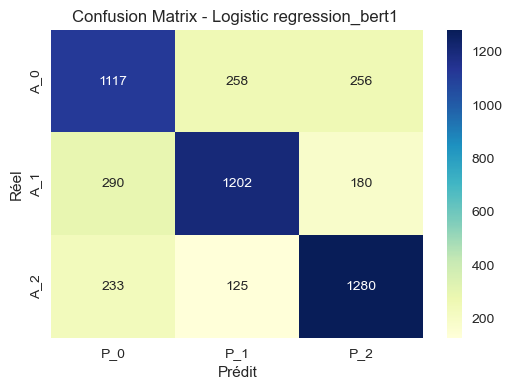


Classification Report – Logistic regression_bert1 

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1631
           1       0.76      0.72      0.74      1672
           2       0.75      0.78      0.76      1638

    accuracy                           0.73      4941
   macro avg       0.73      0.73      0.73      4941
weighted avg       0.73      0.73      0.73      4941


Metrics – Logistic regression_bert1 
Model              Logistic regression_bert1 
AUC Score                            0.796338
MCC                                  0.592894
Precision Score                      0.728732
Recall Score                         0.728395
f1-score                             0.728247
Accuracy Score                       0.728395
Train Accuracy                       0.755276
CV                                   0.725267
dtype: object



In [11]:
logreg_bert = LogisticRegression()
scoring_metrics = ['accuracy', 'f1_weighted']
cv_results = cross_validate(logreg_bert, X_train_bert, y_train, cv=5, scoring=scoring_metrics)
    
for metric in scoring_metrics:
        scores = cv_results[f'test_{metric}']
        print(f"Cross-val {metric}: {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Entraîner le modèle sur tout l'ensemble d'entraînement
logreg_bert.fit(X_train_bert, y_train)
result_tabulation1=Model_Evaluation1(logreg_bert ,"Logistic regression_bert1 ",  X_train_bert, y_train, 
                     X_test_bert,  y_test, result_tabulation1)



Validation croisée (accuracy) : [0.5403491  0.51239879 0.53669028 0.53795547 0.51973684]
Moyenne : 0.5294 | Écart-type : 0.0112


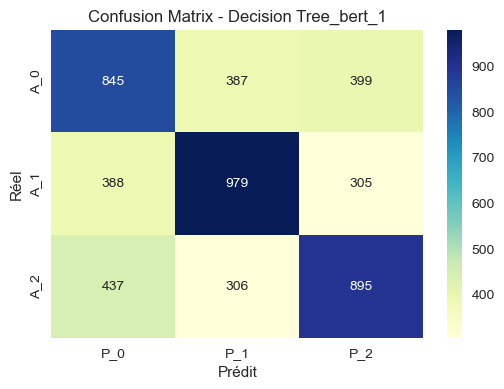


Classification Report – Decision Tree_bert_1

              precision    recall  f1-score   support

           0       0.51      0.52      0.51      1631
           1       0.59      0.59      0.59      1672
           2       0.56      0.55      0.55      1638

    accuracy                           0.55      4941
   macro avg       0.55      0.55      0.55      4941
weighted avg       0.55      0.55      0.55      4941


Metrics – Decision Tree_bert_1
Model              Decision Tree_bert_1
AUC Score                      0.662606
MCC                            0.325442
Precision Score                0.550718
Recall Score                   0.550293
f1-score                       0.550455
Accuracy Score                 0.550293
Train Accuracy                 0.999039
CV                              0.52892
dtype: object



In [28]:
# Initialisation du modèle
decision_tree_classification_bert = DecisionTreeClassifier(random_state=200)

# Validation croisée (par défaut sur accuracy)
cv_scores = cross_val_score(
    decision_tree_classification_bert, 
    X_train_bert, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement sur tout le training set
decision_tree_classification_bert.fit(X_train_bert, y_train)

# Évaluation avec la fonction personnalisée
result_tabulation1 = Model_Evaluation1(
    decision_tree_classification_bert, 
    "Decision Tree_bert_1",   X_train_bert, y_train, 
                     X_test_bert,  y_test,
    result_tabulation1
)

Validation croisée (accuracy) : [0.68378447 0.67661943 0.67839069 0.68117409 0.67611336]
Moyenne : 0.6792 | Écart-type : 0.0029


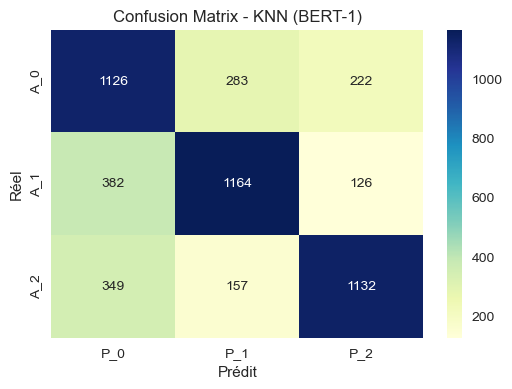


Classification Report – KNN (BERT-1)

              precision    recall  f1-score   support

           0       0.61      0.69      0.65      1631
           1       0.73      0.70      0.71      1672
           2       0.76      0.69      0.73      1638

    accuracy                           0.69      4941
   macro avg       0.70      0.69      0.69      4941
weighted avg       0.70      0.69      0.69      4941


Metrics – KNN (BERT-1)
Model              KNN (BERT-1)
AUC Score              0.769472
MCC                    0.540282
Precision Score        0.699283
Recall Score           0.692572
f1-score               0.694306
Accuracy Score         0.692572
Train Accuracy         0.784829
CV                     0.675244
dtype: object



In [29]:
# Initialisation du modèle KNN
knn_bert = KNeighborsClassifier(n_neighbors=5)  # Tu peux ajuster le nombre de voisins

# Validation croisée
cv_scores = cross_val_score(
    knn_bert, 
    X_train_bert, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final sur toutes les données d'entraînement
knn_bert.fit(X_train_bert, y_train)

# Évaluation finale sur le test set
result_tabulation1 = Model_Evaluation1(
    knn_bert, 
    "KNN (BERT-1)", 
    X_train_bert, y_train, 
    X_test_bert, y_test, 
    result_tabulation1
)

Validation croisée (accuracy) : [0.71970655 0.71508097 0.72165992 0.71356275 0.71963563]
Moyenne : 0.7179 | Écart-type : 0.0031


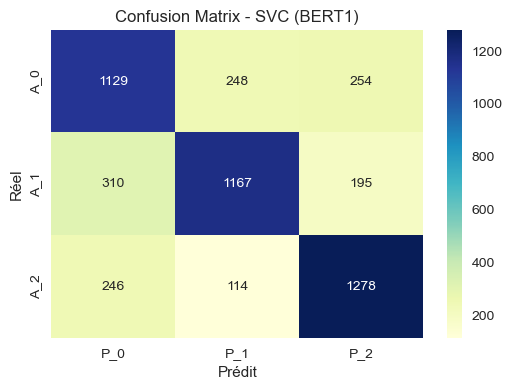


Classification Report – SVC (BERT1)

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1631
           1       0.76      0.70      0.73      1672
           2       0.74      0.78      0.76      1638

    accuracy                           0.72      4941
   macro avg       0.72      0.72      0.72      4941
weighted avg       0.72      0.72      0.72      4941


Metrics – SVC (BERT1)
Model              SVC (BERT1)
AUC Score             0.792625
MCC                   0.585675
Precision Score       0.724773
Recall Score          0.723335
f1-score              0.723325
Accuracy Score        0.723335
Train Accuracy        0.774101
CV                    0.722205
dtype: object



In [16]:
# Initialisation du modèle SVC
svc_bert = SVC(kernel='linear', C=1, random_state=42)  # kernel='linear' souvent bien pour BERT

# Validation croisée
cv_scores = cross_val_score(
    svc_bert, 
    X_train_bert, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final sur le training set complet
svc_bert.fit(X_train_bert, y_train)

# Évaluation finale sur le test set
result_tabulation1 = Model_Evaluation1(
    svc_bert, 
    "SVC (BERT1)", 
    X_train_bert, y_train, 
    X_test_bert, y_test, 
    result_tabulation1
)

In [22]:
run_all_learning_curves(
    model=svc_bert,
    model_class=SVC,  # classe du modèle sans parenthèses
    X_train=X_train_bert,
    y_train=y_train,
    X_test=X_test_bert,
    y_test=y_test
)


🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE

📈 1. Courbe d'apprentissage classique...


KeyboardInterrupt: 

Validation croisée (accuracy) : [0.69618012 0.67282389 0.68522267 0.66978745 0.68041498]
Moyenne : 0.6809 | Écart-type : 0.0094


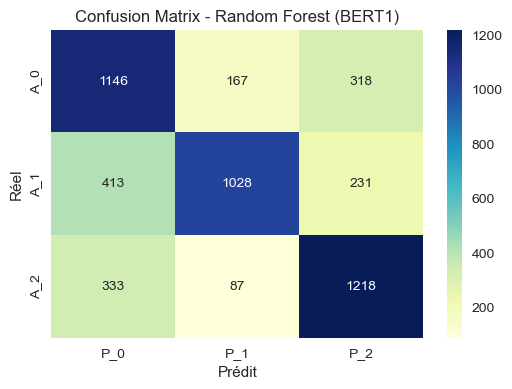


Classification Report – Random Forest (BERT1)

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1631
           1       0.80      0.61      0.70      1672
           2       0.69      0.74      0.72      1638

    accuracy                           0.69      4941
   macro avg       0.70      0.69      0.69      4941
weighted avg       0.70      0.69      0.69      4941


Metrics – Random Forest (BERT1)
Model              Random Forest (BERT1)
AUC Score                       0.765295
MCC                             0.534052
Precision Score                 0.699802
Recall Score                    0.686501
f1-score                        0.687447
Accuracy Score                  0.686501
Train Accuracy                  0.999039
CV                              0.677546
dtype: object



In [31]:
# Initialiser le modèle Random Forest
rf_bert = RandomForestClassifier(
    n_estimators=100,      # nombre d’arbres dans la forêt
    max_depth=None,        # profondeur maximale (None = jusqu’à pureté)
    random_state=42        # pour la reproductibilité
)

# Validation croisée (5 folds, accuracy)
cv_scores = cross_val_score(
    rf_bert,
    X_train_bert,
    y_train,
    cv=5,
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final sur tout le jeu d'entraînement
rf_bert.fit(X_train_bert, y_train)

# Évaluation sur les données de test
result_tabulation1 = Model_Evaluation1(
    rf_bert,
    "Random Forest (BERT1)",
    X_train_bert, y_train,
    X_test_bert, y_test,
    result_tabulation1
)

Validation croisée (accuracy) : [0.63243107 0.61336032 0.63107287 0.60931174 0.62626518]
Moyenne : 0.6225 | Écart-type : 0.0094


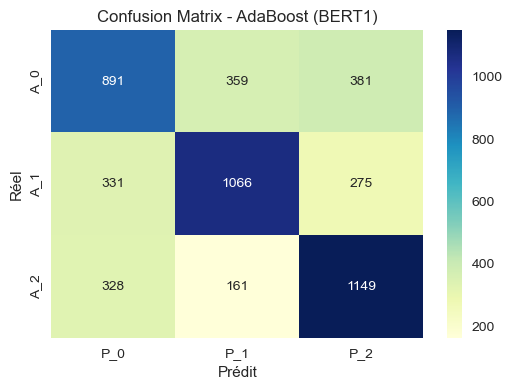


Classification Report – AdaBoost (BERT1)

              precision    recall  f1-score   support

           0       0.57      0.55      0.56      1631
           1       0.67      0.64      0.65      1672
           2       0.64      0.70      0.67      1638

    accuracy                           0.63      4941
   macro avg       0.63      0.63      0.63      4941
weighted avg       0.63      0.63      0.63      4941


Metrics – AdaBoost (BERT1)
Model              AdaBoost (BERT1)
AUC Score                  0.721424
MCC                        0.443545
Precision Score            0.628225
Recall Score               0.628618
f1-score                   0.627625
Accuracy Score             0.628618
Train Accuracy             0.642275
CV                         0.622108
dtype: object



In [32]:
# Initialisation du classifieur AdaBoost
adaboost_bert = AdaBoostClassifier(
    n_estimators=50,         # nombre de classifieurs faibles (default: 50)
    learning_rate=1.0,       # taux d’apprentissage
    random_state=42
)

# Validation croisée sur les représentations BERT
cv_scores = cross_val_score(
    adaboost_bert,
    X_train_bert,
    y_train,
    cv=5,
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final
adaboost_bert.fit(X_train_bert, y_train)

# Évaluation avec ta fonction personnalisée
result_tabulation1 = Model_Evaluation1(
    adaboost_bert,
    "AdaBoost (BERT1)",
    X_train_bert, y_train,
    X_test_bert, y_test,
    result_tabulation1
)

bert2


Cross-val accuracy: 1.0000 ± 0.0000
Cross-val f1_weighted: 1.0000 ± 0.0000


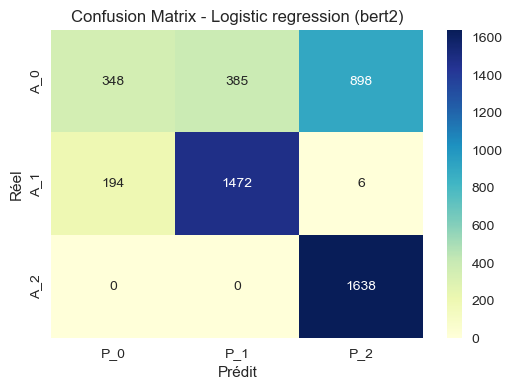


Classification Report – Logistic regression (bert2)

              precision    recall  f1-score   support

           0       0.64      0.21      0.32      1631
           1       0.79      0.88      0.83      1672
           2       0.64      1.00      0.78      1638

    accuracy                           0.70      4941
   macro avg       0.69      0.70      0.65      4941
weighted avg       0.69      0.70      0.65      4941


Metrics – Logistic regression (bert2)
Model              Logistic regression (bert2)
AUC Score                             0.773946
MCC                                   0.587442
Precision Score                       0.693797
Recall Score                          0.699858
f1-score                              0.647842
Accuracy Score                        0.699858
Train Accuracy                        0.688933
CV                                         1.0
dtype: object



In [22]:
logreg_bert_2 = LogisticRegression()
scoring_metrics = ['accuracy', 'f1_weighted']
cv_results = cross_validate(logreg_bert_2, X_train_bert_2, y_train, cv=5, scoring=scoring_metrics)
    
for metric in scoring_metrics:
        scores = cv_results[f'test_{metric}']
        print(f"Cross-val {metric}: {scores.mean():.4f} ± {scores.std():.4f}")
    
    # Entraîner le modèle sur tout l'ensemble d'entraînement
logreg_bert_2.fit(X_train_bert, y_train)
result_tabulation1=Model_Evaluation1(logreg_bert_2 ,"Logistic regression (bert2)",  X_train_bert_2, y_train, 
                     X_test_bert_2,  y_test, result_tabulation1)



🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE

📈 1. Courbe d'apprentissage classique...


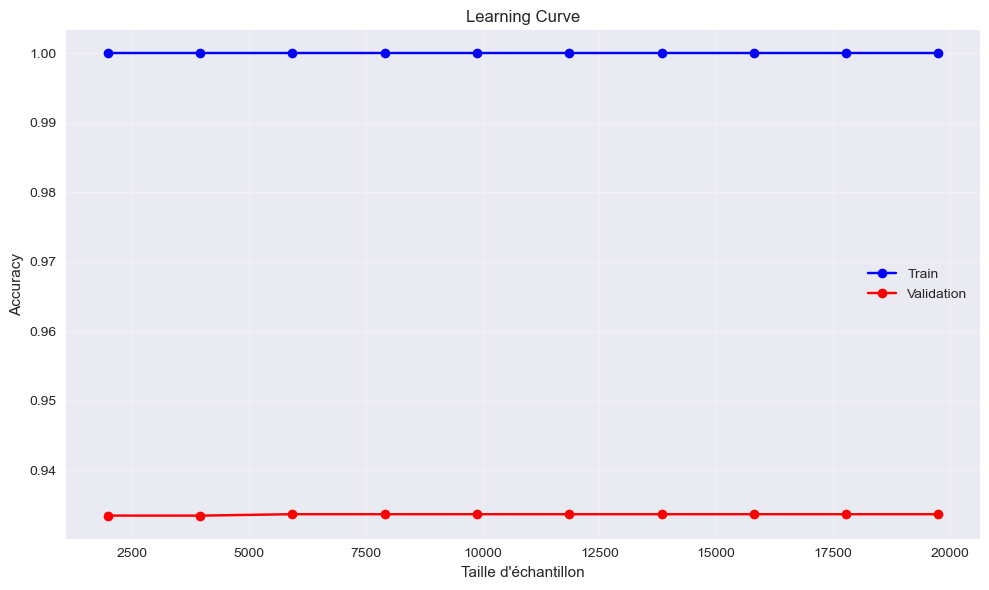


📈 2. Courbe de validation automatique...
⚠️ Le modèle ne possède pas le paramètre 'n_estimators'. Courbe ignorée.

📈 3. Courbe manuelle si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.

📈 4. Métriques multiples si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.


In [23]:
run_all_learning_curves(
    model=logreg_bert_2,
    model_class=LogisticRegression,  # classe du modèle sans parenthèses
    X_train=X_train_bert_2,
    y_train=y_train,
    X_test=X_test_bert_2,
    y_test=y_test
)


Validation croisée (accuracy) : [1.         1.         0.99974696 1.         0.99974696]
Moyenne : 0.9999 | Écart-type : 0.0001


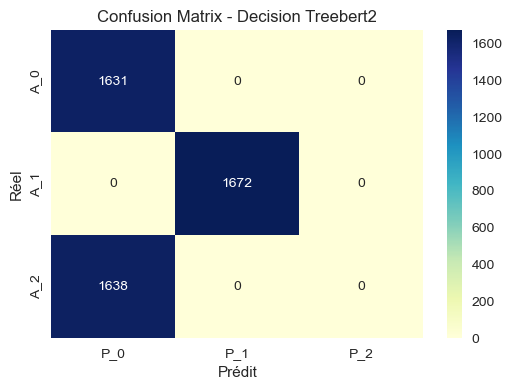


Classification Report – Decision Treebert2

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1631
           1       1.00      1.00      1.00      1672
           2       0.00      0.00      0.00      1638

    accuracy                           0.67      4941
   macro avg       0.50      0.67      0.56      4941
weighted avg       0.50      0.67      0.56      4941


Metrics – Decision Treebert2
Model              Decision Treebert2
AUC Score                    0.750856
MCC                          0.614236
Precision Score              0.503087
Recall Score                 0.668488
f1-score                     0.558142
Accuracy Score               0.668488
Train Accuracy                    1.0
CV                           0.999899
dtype: object



In [24]:
# Initialisation du modèle
decision_tree_classification_bert_2 = DecisionTreeClassifier(random_state=200)

# Validation croisée (par défaut sur accuracy)
cv_scores = cross_val_score(
    decision_tree_classification_bert_2, 
    X_train_bert_2, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement sur tout le training set
decision_tree_classification_bert_2.fit(X_train_bert_2, y_train)

# Évaluation avec la fonction personnalisée
result_tabulation1 = Model_Evaluation1(
    decision_tree_classification_bert_2, 
    "Decision Treebert2",   X_train_bert_2, y_train, 
                     X_test_bert_2,  y_test,
    result_tabulation1
)

🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE

📈 1. Courbe d'apprentissage classique...


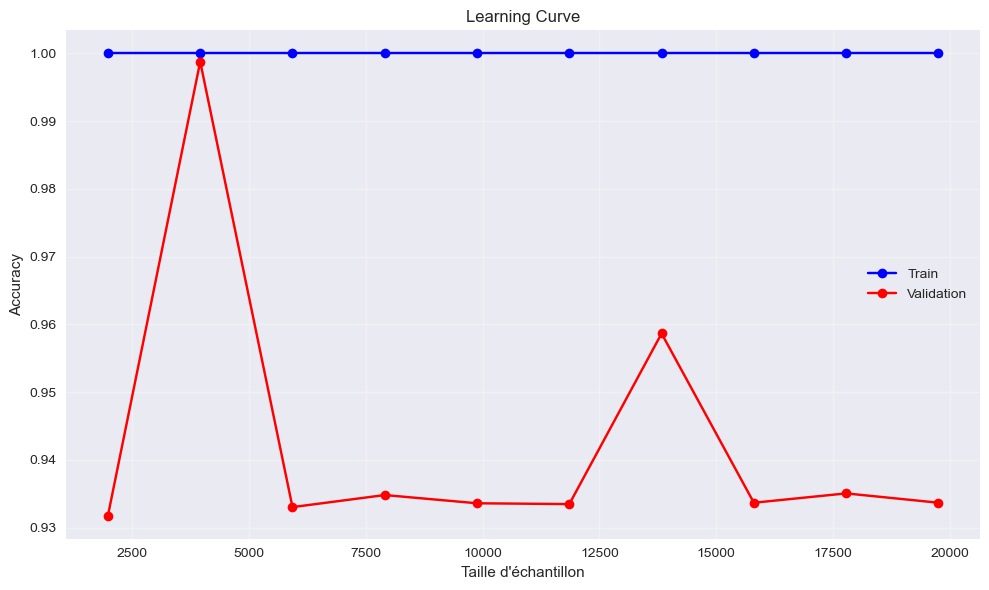


📈 2. Courbe de validation automatique...
⚠️ Le modèle ne possède pas le paramètre 'n_estimators'. Courbe ignorée.

📈 3. Courbe manuelle si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.

📈 4. Métriques multiples si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.


In [25]:
run_all_learning_curves(
    model=decision_tree_classification_bert_2,
    model_class=DecisionTreeClassifier,  # classe du modèle sans parenthèses
    X_train=X_train_bert_2,
    y_train=y_train,
    X_test=X_test_bert_2,
    y_test=y_test
)


Validation croisée (accuracy) : [1. 1. 1. 1. 1.]
Moyenne : 1.0000 | Écart-type : 0.0000


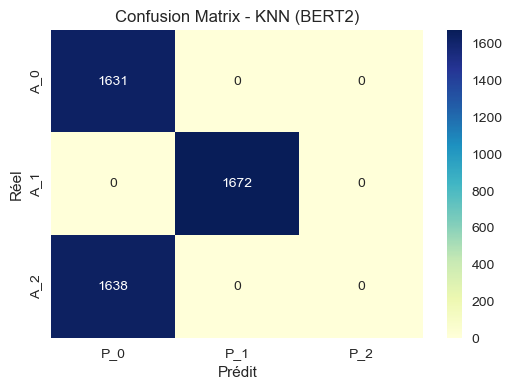


Classification Report – KNN (BERT2)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1631
           1       1.00      1.00      1.00      1672
           2       0.00      0.00      0.00      1638

    accuracy                           0.67      4941
   macro avg       0.50      0.67      0.56      4941
weighted avg       0.50      0.67      0.56      4941


Metrics – KNN (BERT2)
Model              KNN (BERT2)
AUC Score             0.750856
MCC                   0.614236
Precision Score       0.503087
Recall Score          0.668488
f1-score              0.558142
Accuracy Score        0.668488
Train Accuracy             1.0
CV                         1.0
dtype: object



In [35]:
# Initialisation du modèle KNN
knn_bert_2 = KNeighborsClassifier(n_neighbors=5)  # Tu peux ajuster le nombre de voisins

# Validation croisée
cv_scores = cross_val_score(
    knn_bert_2, 
    X_train_bert_2, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final sur toutes les données d'entraînement
knn_bert_2.fit(X_train_bert_2, y_train)

# Évaluation finale sur le test set
result_tabulation1 = Model_Evaluation1(
    knn_bert_2, 
    "KNN (BERT2)", 
    X_train_bert_2, y_train, 
    X_test_bert_2, y_test, 
    result_tabulation1
)

Validation croisée (accuracy) : [1. 1. 1. 1. 1.]
Moyenne : 1.0000 | Écart-type : 0.0000


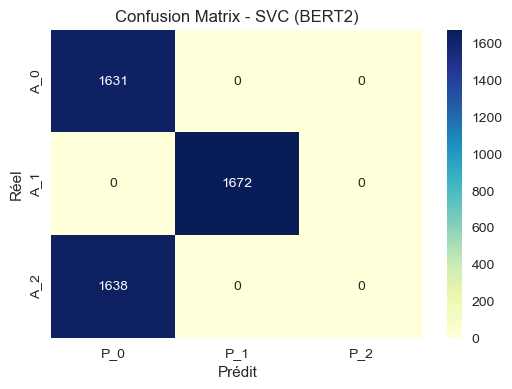


Classification Report – SVC (BERT2)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1631
           1       1.00      1.00      1.00      1672
           2       0.00      0.00      0.00      1638

    accuracy                           0.67      4941
   macro avg       0.50      0.67      0.56      4941
weighted avg       0.50      0.67      0.56      4941


Metrics – SVC (BERT2)
Model              SVC (BERT2)
AUC Score             0.750856
MCC                   0.614236
Precision Score       0.503087
Recall Score          0.668488
f1-score              0.558142
Accuracy Score        0.668488
Train Accuracy             1.0
CV                         1.0
dtype: object



In [36]:
# Initialisation du modèle SVC
svc_bert_2 = SVC(kernel='linear', C=1, random_state=42)  # kernel='linear' souvent bien pour BERT

# Validation croisée
cv_scores = cross_val_score(
    svc_bert_2, 
    X_train_bert_2, 
    y_train, 
    cv=5, 
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final sur le training set complet
svc_bert_2.fit(X_train_bert_2, y_train)

# Évaluation finale sur le test set
result_tabulation1 = Model_Evaluation1(
    svc_bert_2, 
    "SVC (BERT2)", 
    X_train_bert_2, y_train, 
    X_test_bert_2, y_test, 
    result_tabulation1
)

Validation croisée (accuracy) : [1. 1. 1. 1. 1.]
Moyenne : 1.0000 | Écart-type : 0.0000


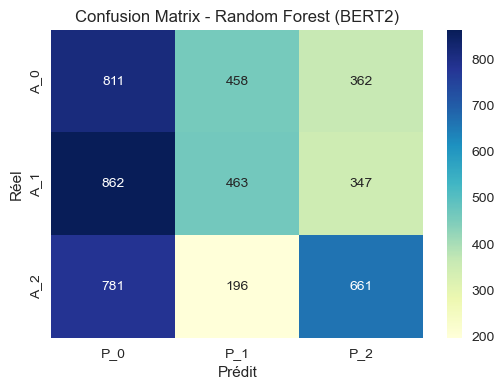


Classification Report – Random Forest (BERT2)

              precision    recall  f1-score   support

           0       0.33      0.50      0.40      1631
           1       0.41      0.28      0.33      1672
           2       0.48      0.40      0.44      1638

    accuracy                           0.39      4941
   macro avg       0.41      0.39      0.39      4941
weighted avg       0.41      0.39      0.39      4941


Metrics – Random Forest (BERT2)
Model              Random Forest (BERT2)
AUC Score                       0.544434
MCC                             0.091779
Precision Score                 0.409304
Recall Score                    0.391621
f1-score                        0.389119
Accuracy Score                  0.391621
Train Accuracy                  0.533171
CV                                   1.0
dtype: object



In [37]:
# Initialiser le modèle Random Forest
rf_bert_2 = RandomForestClassifier(
    n_estimators=100,      # nombre d’arbres dans la forêt
    max_depth=None,        # profondeur maximale (None = jusqu’à pureté)
    random_state=42        # pour la reproductibilité
)

# Validation croisée (5 folds, accuracy)
cv_scores = cross_val_score(
    rf_bert_2,
    X_train_bert_2,
    y_train,
    cv=5,
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final sur tout le jeu d'entraînement
rf_bert_2.fit(X_train_bert_2, y_train)

# Évaluation sur les données de test
result_tabulation1 = Model_Evaluation1(
    rf_bert,
    "Random Forest (BERT2)",
    X_train_bert_2, y_train,
    X_test_bert_2, y_test,
    result_tabulation1
)

Validation croisée (accuracy) : [1.         1.         0.99974696 1.         1.        ]
Moyenne : 0.9999 | Écart-type : 0.0001


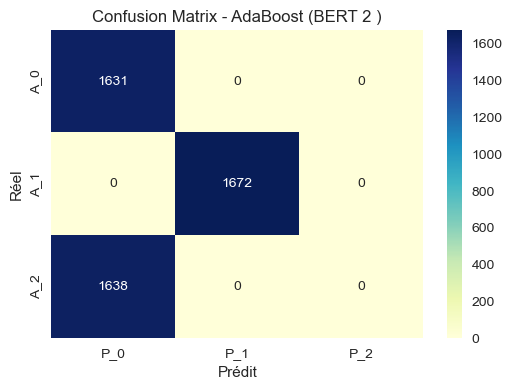


Classification Report – AdaBoost (BERT 2 )

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1631
           1       1.00      1.00      1.00      1672
           2       0.00      0.00      0.00      1638

    accuracy                           0.67      4941
   macro avg       0.50      0.67      0.56      4941
weighted avg       0.50      0.67      0.56      4941


Metrics – AdaBoost (BERT 2 )
Model              AdaBoost (BERT 2 )
AUC Score                    0.750856
MCC                          0.614236
Precision Score              0.503087
Recall Score                 0.668488
f1-score                     0.558142
Accuracy Score               0.668488
Train Accuracy                    1.0
CV                           0.999899
dtype: object



In [38]:
# Initialisation du classifieur AdaBoost
adaboost_bert_2 = AdaBoostClassifier(
    n_estimators=50,         # nombre de classifieurs faibles (default: 50)
    learning_rate=1.0,       # taux d’apprentissage
    random_state=42
)

# Validation croisée sur les représentations BERT
cv_scores = cross_val_score(
    adaboost_bert_2,
    X_train_bert_2,
    y_train,
    cv=5,
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final
adaboost_bert_2.fit(X_train_bert_2, y_train)

# Évaluation avec ta fonction personnalisée
result_tabulation1 = Model_Evaluation1(
    adaboost_bert_2,
    "AdaBoost (BERT 2 )",
    X_train_bert_2, y_train,
    X_test_bert_2, y_test,
    result_tabulation1
)

Validation croisée (accuracy) : [1.         0.99974696 0.99924089 1.         0.99974696]
Moyenne : 0.9997 | Écart-type : 0.0003


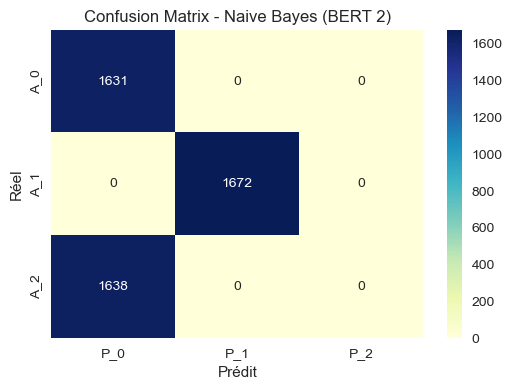


Classification Report – Naive Bayes (BERT 2)

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1631
           1       1.00      1.00      1.00      1672
           2       0.00      0.00      0.00      1638

    accuracy                           0.67      4941
   macro avg       0.50      0.67      0.56      4941
weighted avg       0.50      0.67      0.56      4941


Metrics – Naive Bayes (BERT 2)
Model              Naive Bayes (BERT 2)
AUC Score                      0.750856
MCC                            0.614236
Precision Score                0.503087
Recall Score                   0.668488
f1-score                       0.558142
Accuracy Score                 0.668488
Train Accuracy                 0.999747
CV                             0.999747
dtype: object



In [39]:
X_train_dense = X_train_bert_2.toarray() if hasattr(X_train_bert, "toarray") else X_train_bert_2
X_test_dense = X_test_bert_2.toarray() if hasattr(X_test_bert, "toarray") else X_test_bert_2

# Initialisation du modèle
nb_bert_2 = GaussianNB()

# Validation croisée
cv_scores = cross_val_score(
    nb_bert_2,
    X_train_dense,
    y_train,
    cv=5,
    scoring='accuracy'
)

print(f"Validation croisée (accuracy) : {cv_scores}")
print(f"Moyenne : {np.mean(cv_scores):.4f} | Écart-type : {np.std(cv_scores):.4f}")

# Entraînement final
nb_bert_2.fit(X_train_dense, y_train)

# Évaluation finale
result_tabulation1 = Model_Evaluation1(
    nb_bert_2,
    "Naive Bayes (BERT 2)",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation1
)

tfidf

RF TF-IDF CV accuracy: [0.76549456 0.74822874 0.75885628 0.75151822 0.76518219]
Moyenne: 0.7579, Écart-type: 0.0070


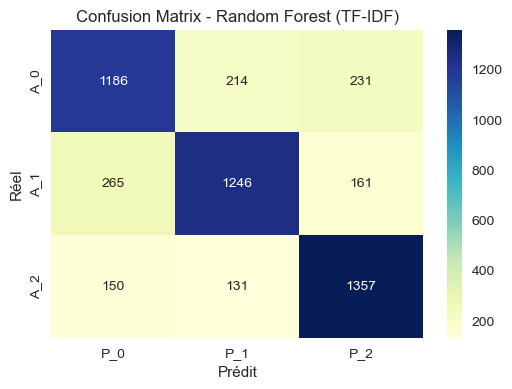


Classification Report – Random Forest (TF-IDF)

              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1631
           1       0.78      0.75      0.76      1672
           2       0.78      0.83      0.80      1638

    accuracy                           0.77      4941
   macro avg       0.77      0.77      0.77      4941
weighted avg       0.77      0.77      0.77      4941


Metrics – Random Forest (TF-IDF)
Model              Random Forest (TF-IDF)
AUC Score                        0.825205
MCC                              0.650703
Precision Score                  0.766755
Recall Score                     0.766849
f1-score                         0.766336
Accuracy Score                   0.766849
Train Accuracy                   0.975912
CV                               0.754592
dtype: object



In [40]:
# --- Random Forest sur X_train_tfidf ---
rf_tfidf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
cv_scores = cross_val_score(rf_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"RF TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
rf_tfidf.fit(X_train_tfidf, y_train)
result_tabulation1 = Model_Evaluation1(rf_tfidf, "Random Forest (TF-IDF)", X_train_tfidf, y_train, X_test_tfidf, y_test, result_tabulation1)


RF TF-IDF CV accuracy: [0.80242854 0.79706478 0.80718623 0.80490891 0.80541498]
Moyenne: 0.8034, Écart-type: 0.0035


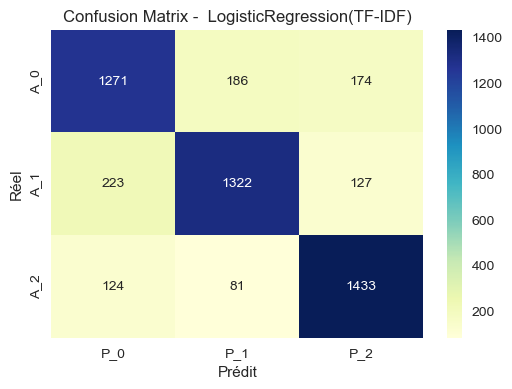


Classification Report –  LogisticRegression(TF-IDF)

              precision    recall  f1-score   support

           0       0.79      0.78      0.78      1631
           1       0.83      0.79      0.81      1672
           2       0.83      0.87      0.85      1638

    accuracy                           0.81      4941
   macro avg       0.81      0.81      0.81      4941
weighted avg       0.81      0.81      0.81      4941


Metrics –  LogisticRegression(TF-IDF)
Model               LogisticRegression(TF-IDF)
AUC Score                             0.861192
MCC                                   0.722614
Precision Score                       0.814801
Recall Score                          0.814815
f1-score                              0.814397
Accuracy Score                        0.814815
Train Accuracy                        0.892364
CV                                    0.804589
dtype: object



In [14]:
# --- Random Forest sur X_train_tfidf ---
lg_tfidf = LogisticRegression(max_iter=30000)
cv_scores = cross_val_score(lg_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"RF TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
lg_tfidf.fit(X_train_tfidf, y_train)
result_tabulation1 = Model_Evaluation1(lg_tfidf, " LogisticRegression(TF-IDF)", X_train_tfidf, y_train, X_test_tfidf, y_test, result_tabulation1)


🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE

📈 1. Courbe d'apprentissage classique...


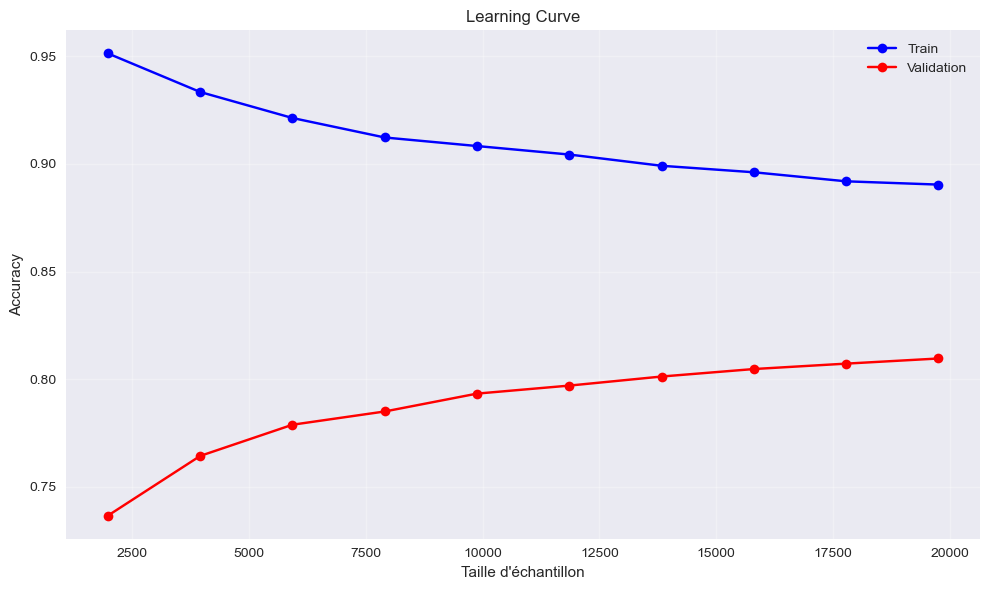


📈 2. Courbe de validation automatique...
⚠️ Le modèle ne possède pas le paramètre 'n_estimators'. Courbe ignorée.

📈 3. Courbe manuelle si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.

📈 4. Métriques multiples si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.


In [15]:
run_all_learning_curves(
    model=lg_tfidf,
    model_class=LogisticRegression,  # classe du modèle sans parenthèses
    X_train=X_train_tfidf,
    y_train=y_train,
    X_test=X_test_tfidf,
    y_test=y_test
)


Decision Tree TF-IDF CV accuracy: [0.71565899 0.68825911 0.70470648 0.70394737 0.70976721]
Moyenne: 0.7045, Écart-type: 0.0091


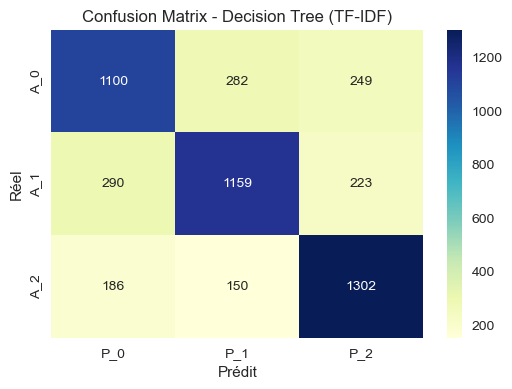


Classification Report – Decision Tree (TF-IDF)

              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1631
           1       0.73      0.69      0.71      1672
           2       0.73      0.79      0.76      1638

    accuracy                           0.72      4941
   macro avg       0.72      0.72      0.72      4941
weighted avg       0.72      0.72      0.72      4941


Metrics – Decision Tree (TF-IDF)
Model              Decision Tree (TF-IDF)
AUC Score                        0.790605
MCC                              0.581595
Precision Score                  0.720214
Recall Score                     0.720704
f1-score                         0.719842
Accuracy Score                   0.720704
Train Accuracy                   0.975912
CV                               0.702393
dtype: object



In [42]:
# --- Decision Tree sur TF-IDF ---
dt_tfidf = DecisionTreeClassifier(random_state=200)
cv_scores = cross_val_score(dt_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"Decision Tree TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
dt_tfidf.fit(X_train_tfidf, y_train)
result_tabulation1 = Model_Evaluation1(dt_tfidf, "Decision Tree (TF-IDF)", X_train_tfidf, y_train, X_test_tfidf, y_test, result_tabulation1)


KNN TF-IDF CV accuracy: [0.52087023 0.52682186 0.53517206 0.53162955 0.53896761]
Moyenne: 0.5307, Écart-type: 0.0063


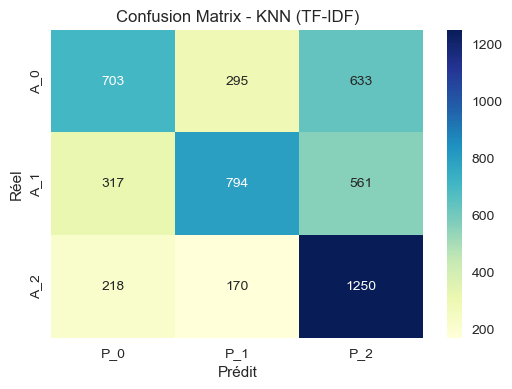


Classification Report – KNN (TF-IDF)

              precision    recall  f1-score   support

           0       0.57      0.43      0.49      1631
           1       0.63      0.47      0.54      1672
           2       0.51      0.76      0.61      1638

    accuracy                           0.56      4941
   macro avg       0.57      0.56      0.55      4941
weighted avg       0.57      0.56      0.55      4941


Metrics – KNN (TF-IDF)
Model              KNN (TF-IDF)
AUC Score              0.667277
MCC                    0.344833
Precision Score         0.57041
Recall Score            0.55596
f1-score               0.548141
Accuracy Score          0.55596
Train Accuracy         0.711553
CV                     0.535246
dtype: object



In [43]:
# --- KNN sur TF-IDF ---
knn_tfidf = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"KNN TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
knn_tfidf.fit(X_train_tfidf, y_train)
result_tabulation1 = Model_Evaluation1(knn_tfidf, "KNN (TF-IDF)", X_train_tfidf, y_train, X_test_tfidf, y_test, result_tabulation1)



SVC TF-IDF CV accuracy: [0.79281558 0.78997976 0.80237854 0.79023279 0.80212551]
Moyenne: 0.7955, Écart-type: 0.0056


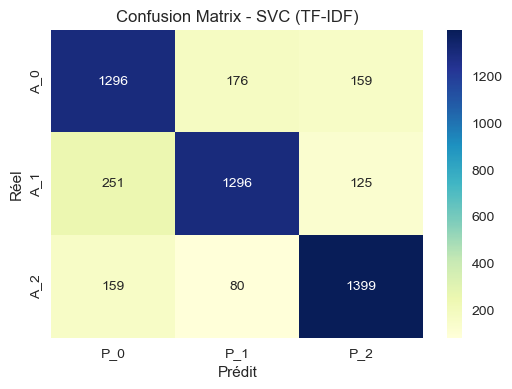


Classification Report – SVC (TF-IDF)

              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1631
           1       0.84      0.78      0.80      1672
           2       0.83      0.85      0.84      1638

    accuracy                           0.81      4941
   macro avg       0.81      0.81      0.81      4941
weighted avg       0.81      0.81      0.81      4941


Metrics – SVC (TF-IDF)
Model              SVC (TF-IDF)
AUC Score              0.855942
MCC                    0.712144
Precision Score         0.80891
Recall Score           0.807731
f1-score               0.807762
Accuracy Score         0.807731
Train Accuracy         0.891858
CV                     0.797024
dtype: object



In [44]:
# --- SVC (kernel=linear) sur TF-IDF ---
svc_tfidf = SVC(kernel='linear', C=1, random_state=42)
cv_scores = cross_val_score(svc_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"SVC TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
svc_tfidf.fit(X_train_tfidf, y_train)
result_tabulation1= Model_Evaluation1(svc_tfidf, "SVC (TF-IDF)", X_train_tfidf, y_train, X_test_tfidf, y_test, result_tabulation1)


AdaBoost TF-IDF CV accuracy: [0.5752593  0.56983806 0.57413968 0.56022267 0.57970648]
Moyenne: 0.5718, Écart-type: 0.0066


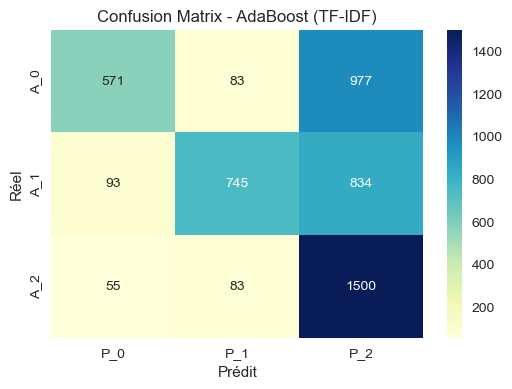


Classification Report – AdaBoost (TF-IDF)

              precision    recall  f1-score   support

           0       0.79      0.35      0.49      1631
           1       0.82      0.45      0.58      1672
           2       0.45      0.92      0.61      1638

    accuracy                           0.57      4941
   macro avg       0.69      0.57      0.56      4941
weighted avg       0.69      0.57      0.56      4941


Metrics – AdaBoost (TF-IDF)
Model              AdaBoost (TF-IDF)
AUC Score                   0.677939
MCC                         0.412859
Precision Score             0.689066
Recall Score                0.569925
f1-score                    0.556571
Accuracy Score              0.569925
Train Accuracy               0.57325
CV                          0.571606
dtype: object



In [45]:
# --- AdaBoost sur TF-IDF ---
adaboost_tfidf = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)
cv_scores = cross_val_score(adaboost_tfidf, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"AdaBoost TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
adaboost_tfidf.fit(X_train_tfidf, y_train)
result_tabulation1 = Model_Evaluation1(adaboost_tfidf, "AdaBoost (TF-IDF)", X_train_tfidf, y_train, X_test_tfidf, y_test, result_tabulation1)


Naive Bayes TF-IDF CV accuracy: [0.72678978 0.72317814 0.72216599 0.71862348 0.73582996]
Moyenne: 0.7253, Écart-type: 0.0059


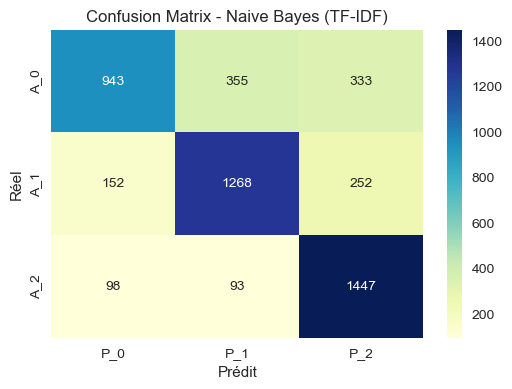


Classification Report – Naive Bayes (TF-IDF)

              precision    recall  f1-score   support

           0       0.79      0.58      0.67      1631
           1       0.74      0.76      0.75      1672
           2       0.71      0.88      0.79      1638

    accuracy                           0.74      4941
   macro avg       0.75      0.74      0.73      4941
weighted avg       0.75      0.74      0.74      4941


Metrics – Naive Bayes (TF-IDF)
Model              Naive Bayes (TF-IDF)
AUC Score                      0.805043
MCC                            0.617028
Precision Score                0.747041
Recall Score                   0.740336
f1-score                       0.735164
Accuracy Score                 0.740336
Train Accuracy                 0.841101
CV                             0.727164
dtype: object



In [46]:

# --- Naive Bayes Gaussian sur TF-IDF (dense) ---
X_train_tfidf_dense = X_train_tfidf.toarray() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf
X_test_tfidf_dense = X_test_tfidf.toarray() if hasattr(X_test_tfidf, "toarray") else X_test_tfidf
nb_tfidf = GaussianNB()
cv_scores = cross_val_score(nb_tfidf, X_train_tfidf_dense, y_train, cv=5, scoring='accuracy')
print(f"Naive Bayes TF-IDF CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f}, Écart-type: {np.std(cv_scores):.4f}")
nb_tfidf.fit(X_train_tfidf_dense, y_train)
result_tabulation1 = Model_Evaluation1(nb_tfidf, "Naive Bayes (TF-IDF)", X_train_tfidf_dense, y_train, X_test_tfidf_dense, y_test, result_tabulation1)

glove

RF GloVe CV accuracy: [0.36959271 0.36285425 0.37196356 0.37348178 0.37424089]
Moyenne: 0.3704 | Écart-type: 0.0041


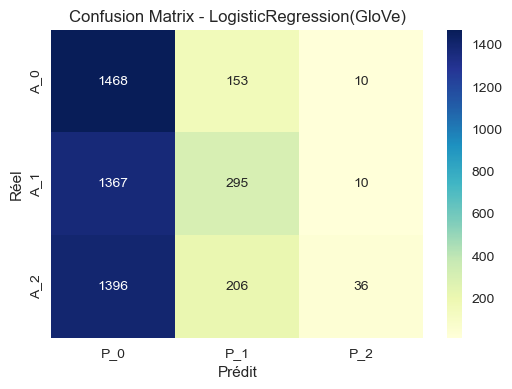


Classification Report – LogisticRegression(GloVe)

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1631
           1       0.45      0.18      0.25      1672
           2       0.64      0.02      0.04      1638

    accuracy                           0.36      4941
   macro avg       0.48      0.37      0.27      4941
weighted avg       0.48      0.36      0.27      4941


Metrics – LogisticRegression(GloVe)
Model              LogisticRegression(GloVe)
AUC Score                           0.524643
MCC                                 0.080705
Precision Score                     0.480285
Recall Score                        0.364096
f1-score                            0.265254
Accuracy Score                      0.364096
Train Accuracy                      0.373463
CV                                  0.371464
dtype: object



In [47]:
# --- Random Forest ---
lg_glove = LogisticRegression()
cv_scores = cross_val_score(lg_glove, X_train_glove, y_train, cv=5, scoring='accuracy')
print(f"RF GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
lg_glove.fit(X_train_glove, y_train)
result_tabulation1 = Model_Evaluation1(lg_glove, "LogisticRegression(GloVe)", X_train_glove, y_train, X_test_glove, y_test, result_tabulation1)



RF GloVe CV accuracy: [0.37136352 0.36361336 0.37854251 0.37322874 0.37322874]
Moyenne: 0.3720 | Écart-type: 0.0048


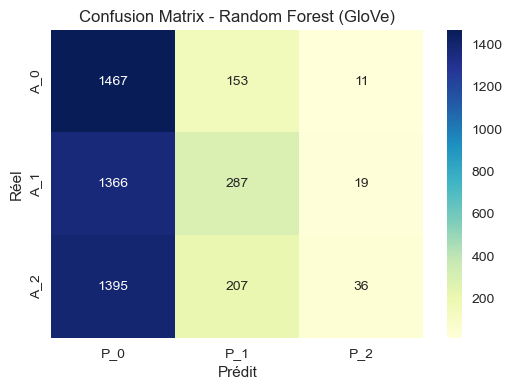


Classification Report – Random Forest (GloVe)

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1631
           1       0.44      0.17      0.25      1672
           2       0.55      0.02      0.04      1638

    accuracy                           0.36      4941
   macro avg       0.45      0.36      0.26      4941
weighted avg       0.45      0.36      0.26      4941


Metrics – Random Forest (GloVe)
Model              Random Forest (GloVe)
AUC Score                       0.523288
MCC                             0.076049
Precision Score                 0.445465
Recall Score                    0.362275
f1-score                        0.263068
Accuracy Score                  0.362275
Train Accuracy                  0.375133
CV                              0.372046
dtype: object



In [48]:
# --- Random Forest ---
rf_glove = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_glove, X_train_glove, y_train, cv=5, scoring='accuracy')
print(f"RF GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
rf_glove.fit(X_train_glove, y_train)
result_tabulation1 = Model_Evaluation1(rf_glove, "Random Forest (GloVe)", X_train_glove, y_train, X_test_glove, y_test, result_tabulation1)



Decision Tree GloVe CV accuracy: [0.37085758 0.36310729 0.37803644 0.37322874 0.37348178]
Moyenne: 0.3717 | Écart-type: 0.0049


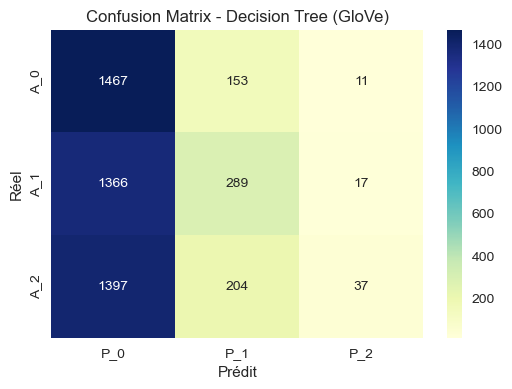


Classification Report – Decision Tree (GloVe)

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1631
           1       0.45      0.17      0.25      1672
           2       0.57      0.02      0.04      1638

    accuracy                           0.36      4941
   macro avg       0.45      0.36      0.26      4941
weighted avg       0.45      0.36      0.26      4941


Metrics – Decision Tree (GloVe)
Model              Decision Tree (GloVe)
AUC Score                       0.523743
MCC                             0.077638
Precision Score                 0.454573
Recall Score                    0.362882
f1-score                        0.264029
Accuracy Score                  0.362882
Train Accuracy                  0.375133
CV                              0.371717
dtype: object



In [49]:
# --- Decision Tree ---
dt_glove = DecisionTreeClassifier(random_state=200)
cv_scores = cross_val_score(dt_glove, X_train_glove, y_train, cv=5, scoring='accuracy')
print(f"Decision Tree GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
dt_glove.fit(X_train_glove, y_train)
result_tabulation1 = Model_Evaluation1(dt_glove, "Decision Tree (GloVe)", X_train_glove, y_train, X_test_glove, y_test, result_tabulation1)



KNN GloVe CV accuracy: [0.35643815 0.33552632 0.33830972 0.33932186 0.33856275]
Moyenne: 0.3416 | Écart-type: 0.0075


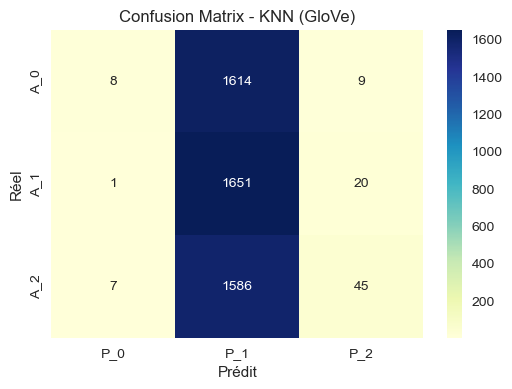


Classification Report – KNN (GloVe)

              precision    recall  f1-score   support

           0       0.50      0.00      0.01      1631
           1       0.34      0.99      0.51      1672
           2       0.61      0.03      0.05      1638

    accuracy                           0.34      4941
   macro avg       0.48      0.34      0.19      4941
weighted avg       0.48      0.34      0.19      4941


Metrics – KNN (GloVe)
Model              KNN (GloVe)
AUC Score             0.504955
MCC                   0.042726
Precision Score       0.481812
Recall Score          0.344869
f1-score              0.191932
Accuracy Score        0.344869
Train Accuracy         0.33976
CV                    0.351602
dtype: object



In [28]:
# --- KNN ---
knn_glove = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_glove, X_train_glove, y_train, cv=5, scoring='accuracy')
print(f"KNN GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
knn_glove.fit(X_train_glove, y_train)
result_tabulation1 = Model_Evaluation1(knn_glove, "KNN (GloVe)", X_train_glove, y_train, X_test_glove, y_test, result_tabulation1)



🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE

📈 1. Courbe d'apprentissage classique...


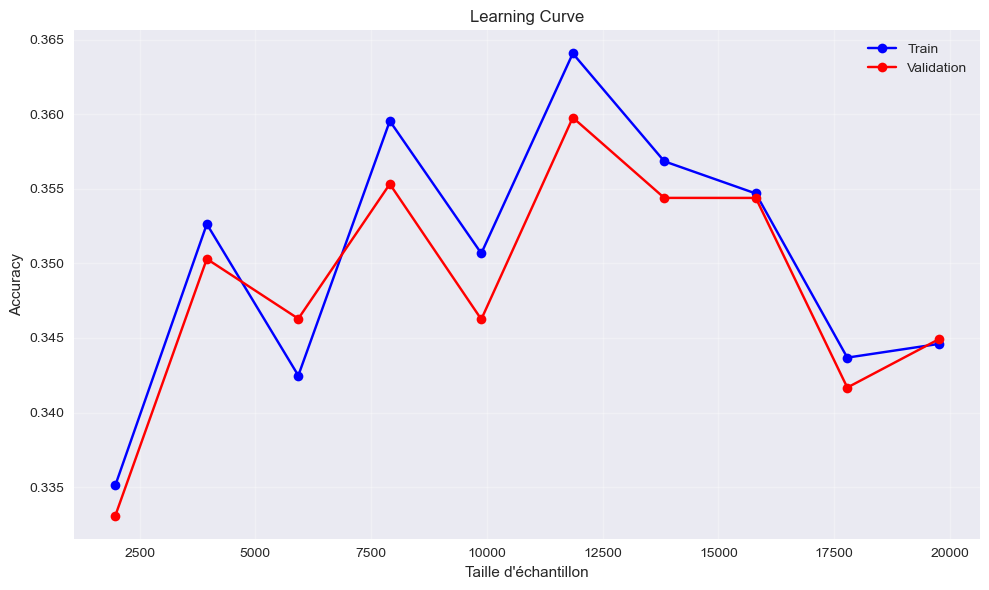


📈 2. Courbe de validation automatique...
⚠️ Le modèle ne possède pas le paramètre 'n_estimators'. Courbe ignorée.

📈 3. Courbe manuelle si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.

📈 4. Métriques multiples si applicable...
⚠️ Le modèle ne supporte pas la variation de 'n_estimators'. Courbe ignorée.


In [29]:
run_all_learning_curves(
    model=knn_glove,
    model_class=KNeighborsClassifier,  # classe du modèle sans parenthèses
    X_train=X_train_glove,
    y_train=y_train,
    X_test=X_test_glove,
    y_test=y_test
)

SVC GloVe CV accuracy: [0.36756893 0.36260121 0.37677126 0.37297571 0.37171053]
Moyenne: 0.3703 | Écart-type: 0.0049


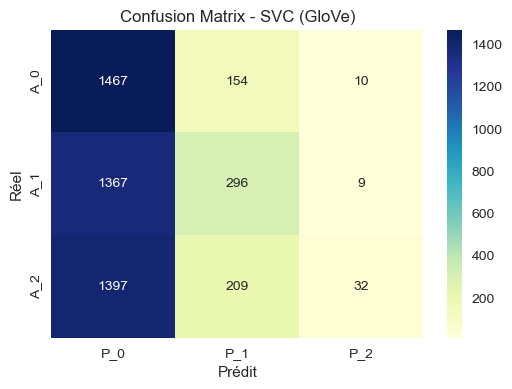


Classification Report – SVC (GloVe)

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1631
           1       0.45      0.18      0.25      1672
           2       0.63      0.02      0.04      1638

    accuracy                           0.36      4941
   macro avg       0.47      0.37      0.26      4941
weighted avg       0.47      0.36      0.26      4941


Metrics – SVC (GloVe)
Model              SVC (GloVe)
AUC Score             0.524029
MCC                    0.07874
Precision Score       0.474455
Recall Score          0.363287
f1-score              0.263719
Accuracy Score        0.363287
Train Accuracy        0.373159
CV                    0.370503
dtype: object



In [51]:
# --- SVC (kernel linéaire) ---
svc_glove = SVC(kernel='linear', C=1, random_state=42)
cv_scores = cross_val_score(svc_glove, X_train_glove, y_train, cv=5, scoring='accuracy')
print(f"SVC GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
svc_glove.fit(X_train_glove, y_train)
result_tabulation1 = Model_Evaluation1(svc_glove, "SVC (GloVe)", X_train_glove, y_train, X_test_glove, y_test, result_tabulation1)



AdaBoost GloVe CV accuracy: [0.35770301 0.35475709 0.36184211 0.36082996 0.36260121]
Moyenne: 0.3595 | Écart-type: 0.0029


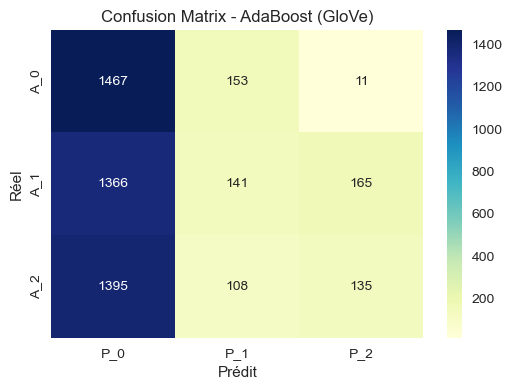


Classification Report – AdaBoost (GloVe)

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1631
           1       0.35      0.08      0.14      1672
           2       0.43      0.08      0.14      1638

    accuracy                           0.35      4941
   macro avg       0.38      0.36      0.26      4941
weighted avg       0.38      0.35      0.26      4941


Metrics – AdaBoost (GloVe)
Model              AdaBoost (GloVe)
AUC Score                  0.516489
MCC                        0.052897
Precision Score            0.377128
Recall Score               0.352763
f1-score                   0.257237
Accuracy Score             0.352763
Train Accuracy             0.361621
CV                           0.3619
dtype: object



In [52]:
# --- AdaBoost ---
adaboost_glove = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)
cv_scores = cross_val_score(adaboost_glove, X_train_glove, y_train, cv=5, scoring='accuracy')
print(f"AdaBoost GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
adaboost_glove.fit(X_train_glove, y_train)
result_tabulation1 = Model_Evaluation1(adaboost_glove, "AdaBoost (GloVe)", X_train_glove, y_train, X_test_glove, y_test, result_tabulation1)


Naive Bayes GloVe CV accuracy: [0.3660511  0.36158907 0.37550607 0.36993927 0.37449393]
Moyenne: 0.3695 | Écart-type: 0.0052


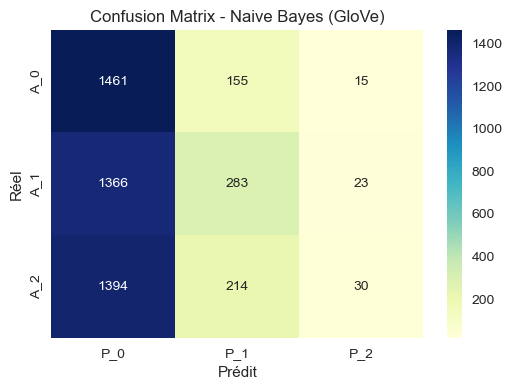


Classification Report – Naive Bayes (GloVe)

              precision    recall  f1-score   support

           0       0.35      0.90      0.50      1631
           1       0.43      0.17      0.24      1672
           2       0.44      0.02      0.04      1638

    accuracy                           0.36      4941
   macro avg       0.41      0.36      0.26      4941
weighted avg       0.41      0.36      0.26      4941


Metrics – Naive Bayes (GloVe)
Model              Naive Bayes (GloVe)
AUC Score                     0.520854
MCC                           0.067812
Precision Score               0.407389
Recall Score                  0.359037
f1-score                      0.258895
Accuracy Score                0.359037
Train Accuracy                0.370325
CV                            0.369592
dtype: object



In [53]:

# --- Naive Bayes (données denses requises) ---
X_train_glove_dense = X_train_glove.toarray() if hasattr(X_train_glove, "toarray") else X_train_glove
X_test_glove_dense = X_test_glove.toarray() if hasattr(X_test_glove, "toarray") else X_test_glove
nb_glove = GaussianNB()
cv_scores = cross_val_score(nb_glove, X_train_glove_dense, y_train, cv=5, scoring='accuracy')
print(f"Naive Bayes GloVe CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
nb_glove.fit(X_train_glove_dense, y_train)
result_tabulation1 = Model_Evaluation1(nb_glove, "Naive Bayes (GloVe)", X_train_glove_dense, y_train, X_test_glove_dense, y_test, result_tabulation1)

w2v

RF Word2Vec CV accuracy: [0.53807235 0.53694332 0.55187247 0.51796559 0.54908907]
Moyenne: 0.5388 | Écart-type: 0.0120


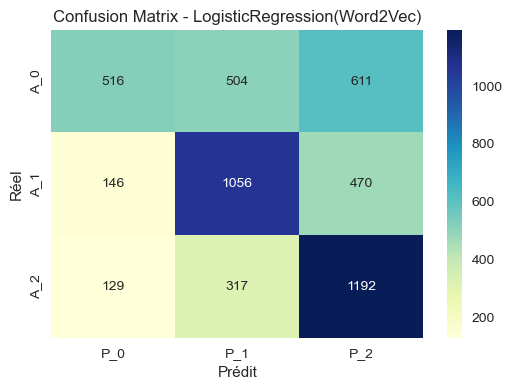


Classification Report – LogisticRegression(Word2Vec)

              precision    recall  f1-score   support

           0       0.65      0.32      0.43      1631
           1       0.56      0.63      0.60      1672
           2       0.52      0.73      0.61      1638

    accuracy                           0.56      4941
   macro avg       0.58      0.56      0.54      4941
weighted avg       0.58      0.56      0.54      4941


Metrics – LogisticRegression(Word2Vec)
Model              LogisticRegression(Word2Vec)
AUC Score                              0.669027
MCC                                    0.351206
Precision Score                        0.579564
Recall Score                           0.559401
f1-score                               0.544106
Accuracy Score                         0.559401
Train Accuracy                         0.550681
CV                                     0.539294
dtype: object



In [54]:

# --- Random Forest ---
lg_w2v = LogisticRegression()
cv_scores = cross_val_score(lg_w2v, X_train_w2v, y_train, cv=5, scoring='accuracy')
print(f"RF Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
lg_w2v.fit(X_train_w2v, y_train)
result_tabulation1 = Model_Evaluation1(lg_w2v, "LogisticRegression(Word2Vec)", X_train_w2v, y_train, X_test_w2v, y_test, result_tabulation1)




RF Word2Vec CV accuracy: [0.57222363 0.57388664 0.57464575 0.5597166  0.57312753]
Moyenne: 0.5707 | Écart-type: 0.0056


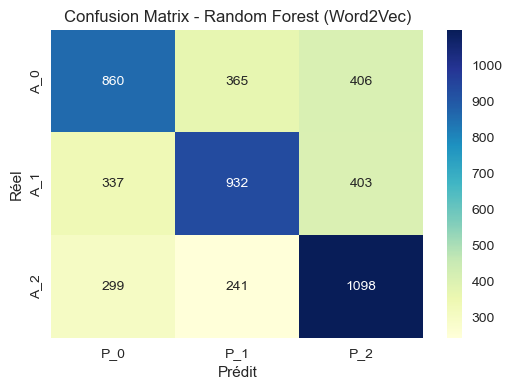


Classification Report – Random Forest (Word2Vec)

              precision    recall  f1-score   support

           0       0.57      0.53      0.55      1631
           1       0.61      0.56      0.58      1672
           2       0.58      0.67      0.62      1638

    accuracy                           0.58      4941
   macro avg       0.59      0.59      0.58      4941
weighted avg       0.59      0.58      0.58      4941


Metrics – Random Forest (Word2Vec)
Model              Random Forest (Word2Vec)
AUC Score                          0.688763
MCC                                0.378719
Precision Score                    0.585696
Recall Score                       0.584902
f1-score                           0.583428
Accuracy Score                     0.584902
Train Accuracy                     0.998887
CV                                 0.570391
dtype: object



In [55]:

# --- Random Forest ---
rf_w2v = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_w2v, X_train_w2v, y_train, cv=5, scoring='accuracy')
print(f"RF Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
rf_w2v.fit(X_train_w2v, y_train)
result_tabulation1 = Model_Evaluation1(rf_w2v, "Random Forest (Word2Vec)", X_train_w2v, y_train, X_test_w2v, y_test, result_tabulation1)




Decision Tree Word2Vec CV accuracy: [0.44801417 0.46761134 0.45976721 0.47115385 0.46811741]
Moyenne: 0.4629 | Écart-type: 0.0084


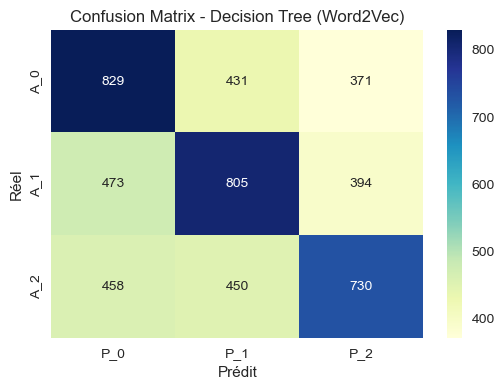


Classification Report – Decision Tree (Word2Vec)

              precision    recall  f1-score   support

           0       0.47      0.51      0.49      1631
           1       0.48      0.48      0.48      1672
           2       0.49      0.45      0.47      1638

    accuracy                           0.48      4941
   macro avg       0.48      0.48      0.48      4941
weighted avg       0.48      0.48      0.48      4941


Metrics – Decision Tree (Word2Vec)
Model              Decision Tree (Word2Vec)
AUC Score                          0.608837
MCC                                0.217893
Precision Score                    0.478927
Recall Score                       0.478446
f1-score                           0.478127
Accuracy Score                     0.478446
Train Accuracy                     0.998887
CV                                 0.467866
dtype: object



In [56]:
# --- Decision Tree ---
dt_w2v = DecisionTreeClassifier(random_state=200)
cv_scores = cross_val_score(dt_w2v, X_train_w2v, y_train, cv=5, scoring='accuracy')
print(f"Decision Tree Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
dt_w2v.fit(X_train_w2v, y_train)
result_tabulation1 = Model_Evaluation1(dt_w2v, "Decision Tree (Word2Vec)", X_train_w2v, y_train, X_test_w2v, y_test, result_tabulation1)



KNN Word2Vec CV accuracy: [0.48646598 0.48684211 0.48734818 0.48178138 0.48836032]
Moyenne: 0.4862 | Écart-type: 0.0023


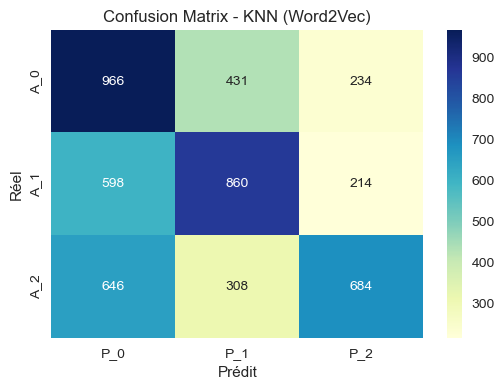


Classification Report – KNN (Word2Vec)

              precision    recall  f1-score   support

           0       0.44      0.59      0.50      1631
           1       0.54      0.51      0.53      1672
           2       0.60      0.42      0.49      1638

    accuracy                           0.51      4941
   macro avg       0.53      0.51      0.51      4941
weighted avg       0.53      0.51      0.51      4941


Metrics – KNN (Word2Vec)
Model              KNN (Word2Vec)
AUC Score                0.631114
MCC                      0.267183
Precision Score          0.526599
Recall Score             0.507994
f1-score                 0.507695
Accuracy Score           0.507994
Train Accuracy           0.671474
CV                       0.487652
dtype: object



In [57]:
# --- KNN ---
knn_w2v = KNeighborsClassifier(n_neighbors=5)
cv_scores = cross_val_score(knn_w2v, X_train_w2v, y_train, cv=5, scoring='accuracy')
print(f"KNN Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
knn_w2v.fit(X_train_w2v, y_train)
result_tabulation1 = Model_Evaluation1(knn_w2v, "KNN (Word2Vec)", X_train_w2v, y_train, X_test_w2v, y_test, result_tabulation1)



SVC Word2Vec CV accuracy: [0.48317733 0.46381579 0.47267206 0.45976721 0.47165992]
Moyenne: 0.4702 | Écart-type: 0.0081


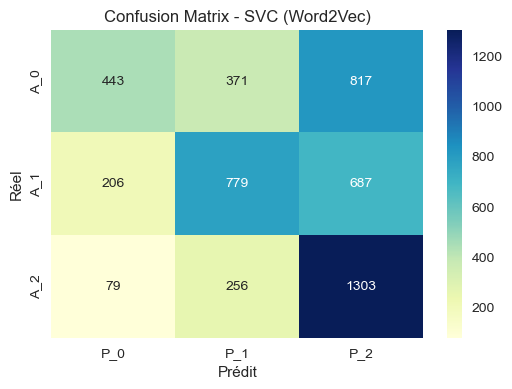


Classification Report – SVC (Word2Vec)

              precision    recall  f1-score   support

           0       0.61      0.27      0.38      1631
           1       0.55      0.47      0.51      1672
           2       0.46      0.80      0.59      1638

    accuracy                           0.51      4941
   macro avg       0.54      0.51      0.49      4941
weighted avg       0.54      0.51      0.49      4941


Metrics – SVC (Word2Vec)
Model              SVC (Word2Vec)
AUC Score                0.633293
MCC                      0.287237
Precision Score          0.542243
Recall Score              0.51103
f1-score                 0.489621
Accuracy Score            0.51103
Train Accuracy           0.480542
CV                       0.470902
dtype: object



In [58]:
# --- SVC (kernel linéaire) ---
svc_w2v = SVC(kernel='linear', C=1, random_state=42)
cv_scores = cross_val_score(svc_w2v, X_train_w2v, y_train, cv=5, scoring='accuracy')
print(f"SVC Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
svc_w2v.fit(X_train_w2v, y_train)
result_tabulation1 = Model_Evaluation1(svc_w2v, "SVC (Word2Vec)", X_train_w2v, y_train, X_test_w2v, y_test, result_tabulation1)



AdaBoost Word2Vec CV accuracy: [0.48570706 0.48304656 0.47317814 0.47899798 0.47317814]
Moyenne: 0.4788 | Écart-type: 0.0051


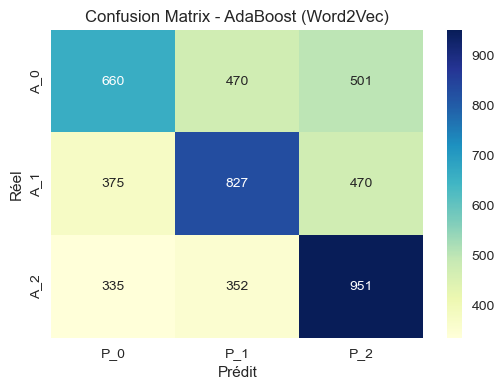


Classification Report – AdaBoost (Word2Vec)

              precision    recall  f1-score   support

           0       0.48      0.40      0.44      1631
           1       0.50      0.49      0.50      1672
           2       0.49      0.58      0.53      1638

    accuracy                           0.49      4941
   macro avg       0.49      0.49      0.49      4941
weighted avg       0.49      0.49      0.49      4941


Metrics – AdaBoost (Word2Vec)
Model              AdaBoost (Word2Vec)
AUC Score                     0.619989
MCC                           0.241149
Precision Score               0.492765
Recall Score                  0.493422
f1-score                      0.490844
Accuracy Score                0.493422
Train Accuracy                0.495673
CV                            0.472015
dtype: object



In [26]:
# --- AdaBoost ---
adaboost_w2v = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=42)
cv_scores = cross_val_score(adaboost_w2v, X_train_w2v, y_train, cv=5, scoring='accuracy')
print(f"AdaBoost Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
adaboost_w2v.fit(X_train_w2v, y_train)
result_tabulation1 = Model_Evaluation1(adaboost_w2v, "AdaBoost (Word2Vec)", X_train_w2v, y_train, X_test_w2v, y_test, result_tabulation1)



🎯 GÉNÉRATION DES COURBES D'APPRENTISSAGE

📈 1. Courbe d'apprentissage classique...


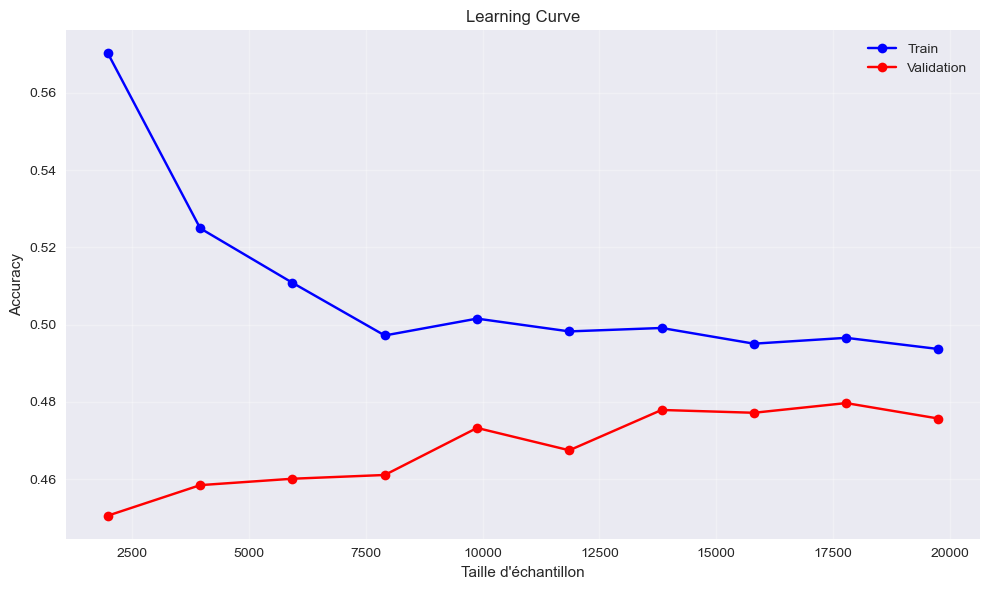


📈 2. Courbe de validation automatique...


KeyboardInterrupt: 

In [27]:
run_all_learning_curves(
    model=adaboost_w2v,
    model_class=AdaBoostClassifier,  # classe du modèle sans parenthèses
    X_train=X_train_w2v,
    y_train=y_train,
    X_test=X_test_w2v,
    y_test=y_test
)

Naive Bayes Word2Vec CV accuracy: [0.41183911 0.39397773 0.41396761 0.3937247  0.41523279]
Moyenne: 0.4057 | Écart-type: 0.0098


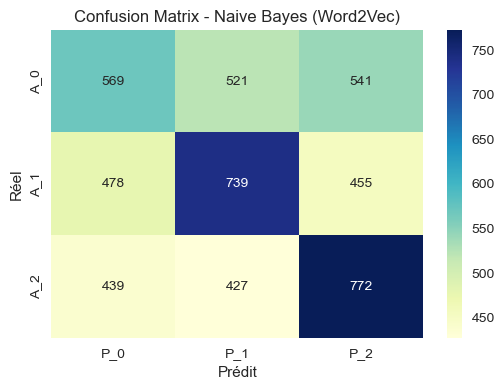


Classification Report – Naive Bayes (Word2Vec)

              precision    recall  f1-score   support

           0       0.38      0.35      0.37      1631
           1       0.44      0.44      0.44      1672
           2       0.44      0.47      0.45      1638

    accuracy                           0.42      4941
   macro avg       0.42      0.42      0.42      4941
weighted avg       0.42      0.42      0.42      4941


Metrics – Naive Bayes (Word2Vec)
Model              Naive Bayes (Word2Vec)
AUC Score                        0.565596
MCC                              0.131473
Precision Score                  0.419386
Recall Score                     0.420967
f1-score                         0.419693
Accuracy Score                   0.420967
Train Accuracy                   0.406811
CV                               0.405344
dtype: object



In [60]:
# --- Naive Bayes (données denses) ---
X_train_w2v_dense = X_train_w2v.toarray() if hasattr(X_train_w2v, "toarray") else X_train_w2v
X_test_w2v_dense = X_test_w2v.toarray() if hasattr(X_test_w2v, "toarray") else X_test_w2v
nb_w2v = GaussianNB()
cv_scores = cross_val_score(nb_w2v, X_train_w2v_dense, y_train, cv=5, scoring='accuracy')
print(f"Naive Bayes Word2Vec CV accuracy: {cv_scores}")
print(f"Moyenne: {np.mean(cv_scores):.4f} | Écart-type: {np.std(cv_scores):.4f}")
nb_w2v.fit(X_train_w2v_dense, y_train)
result_tabulation1 = Model_Evaluation1(nb_w2v, "Naive Bayes (Word2Vec)", X_train_w2v_dense, y_train, X_test_w2v_dense, y_test, result_tabulation1)

In [61]:
result_tabulation1

,Model,AUC Score,MCC,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy,CV
0,Logistic regression_bert1,0.796338,0.592894,0.728732,0.728395,0.728247,0.728395,0.755276,0.725267
1,Decision Tree_bert_1,0.662606,0.325442,0.550718,0.550293,0.550455,0.550293,0.999039,0.52892
2,KNN (BERT-1),0.769472,0.540282,0.699283,0.692572,0.694306,0.692572,0.784829,0.675244
3,SVC (BERT1),0.792625,0.585675,0.724773,0.723335,0.723325,0.723335,0.774101,0.722205
4,Random Forest (BERT1),0.765295,0.534052,0.699802,0.686501,0.687447,0.686501,0.999039,0.677546
5,AdaBoost (BERT1),0.721424,0.443545,0.628225,0.628618,0.627625,0.628618,0.642275,0.622108
6,Logistic regression (bert2),0.773946,0.587442,0.693797,0.699858,0.647842,0.699858,0.688933,1.0
7,Decision Treebert2,0.750856,0.614236,0.503087,0.668488,0.558142,0.668488,1.0,0.999899
8,KNN (BERT2),0.750856,0.614236,0.503087,0.668488,0.558142,0.668488,1.0,1.0
9,SVC (BERT2),0.750856,0.614236,0.503087,0.668488,0.558142,0.668488,1.0,1.0


In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [12]:
X_train_dense = X_train_bert.toarray() if hasattr(X_train_bert, "toarray") else X_train_bert
X_test_dense = X_test_bert.toarray() if hasattr(X_test_bert, "toarray") else X_test_bert
 

In [13]:
param_dist_lr = {
    'C': np.logspace(-3, 3, 10),
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'max_iter': [1000]
}

rs_lr = RandomizedSearchCV(
    LogisticRegression(),
    param_dist_lr,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=4,
    verbose=1,
    random_state=42
)

rs_lr.fit(X_train_dense, y_train)
print("Best Logistic Regression params:", rs_lr.best_params_)

best_lr = rs_lr.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_lr,
    "Logistic Regression (BERT) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best SVC params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 2.1544346900318843}


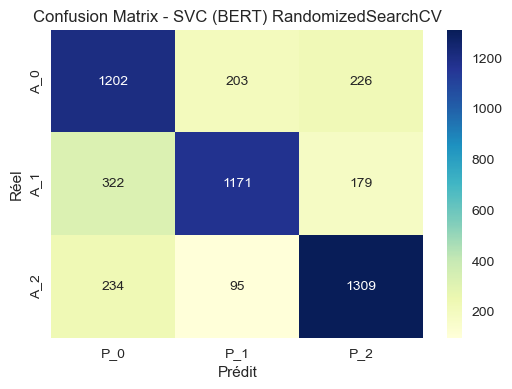


Classification Report – SVC (BERT) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      1631
           1       0.80      0.70      0.75      1672
           2       0.76      0.80      0.78      1638

    accuracy                           0.75      4941
   macro avg       0.75      0.75      0.75      4941
weighted avg       0.75      0.75      0.75      4941


Metrics – SVC (BERT) RandomizedSearchCV
Model              SVC (BERT) RandomizedSearchCV
AUC Score                               0.809121
MCC                                     0.619151
Precision Score                         0.748622
Recall Score                            0.745193
f1-score                                0.745387
Accuracy Score                          0.745193
Train Accuracy                          0.841304
CV                                      0.741916
dtype: object



In [ ]:
param_dist_svc = {
    'C': np.logspace(-3, 2, 10),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

rs_svc = RandomizedSearchCV(
    SVC(),
    param_dist_svc,
    n_iter=15,
    scoring='accuracy',
    cv=5,
    n_jobs=4,
    verbose=1,
    random_state=42
)

rs_svc.fit(X_train_dense, y_train)
print("Best SVC params:", rs_svc.best_params_)

best_svc = rs_svc.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_svc,
    "SVC (BERT) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

In [14]:
X_train_dense = X_train_tfidf.toarray() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf
X_test_dense = X_test_tfidf.toarray() if hasattr(X_test_tfidf, "toarray") else X_test_tfidf


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Logistic Regression params: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': 2.154434690031882}


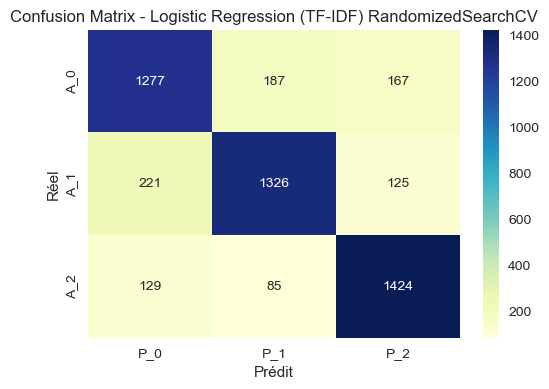


Classification Report – Logistic Regression (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1631
           1       0.83      0.79      0.81      1672
           2       0.83      0.87      0.85      1638

    accuracy                           0.82      4941
   macro avg       0.81      0.82      0.81      4941
weighted avg       0.81      0.82      0.81      4941


Metrics – Logistic Regression (TF-IDF) RandomizedSearchCV
Model              Logistic Regression (TF-IDF) RandomizedSearchCV
AUC Score                                                 0.861337
MCC                                                       0.722809
Precision Score                                            0.81498
Recall Score                                              0.815017
f1-score                                                  0.814705
Accuracy Score                                            0.815017
Train Accuracy   

In [15]:
param_dist_lr = {
    'C': np.logspace(-3, 3, 10),
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'max_iter': [1000]
}

rs_lr = RandomizedSearchCV(
    LogisticRegression(),
    param_dist_lr,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=6,
    verbose=1,
    random_state=42
)

rs_lr.fit(X_train_dense, y_train)
print("Best Logistic Regression params:", rs_lr.best_params_)

best_lr = rs_lr.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_lr,
    "Logistic Regression (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Decision Tree params: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}


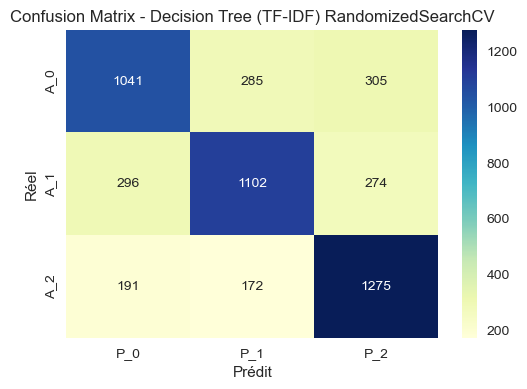


Classification Report – Decision Tree (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      1631
           1       0.71      0.66      0.68      1672
           2       0.69      0.78      0.73      1638

    accuracy                           0.69      4941
   macro avg       0.69      0.69      0.69      4941
weighted avg       0.69      0.69      0.69      4941


Metrics – Decision Tree (TF-IDF) RandomizedSearchCV
Model              Decision Tree (TF-IDF) RandomizedSearchCV
AUC Score                                           0.768919
MCC                                                 0.538866
Precision Score                                     0.692067
Recall Score                                        0.691763
f1-score                                            0.690471
Accuracy Score                                      0.691763
Train Accuracy                                      0.816406
CV        

In [ ]:
param_dist_dt = {
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rs_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_dist_dt,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=6,
    verbose=1,
    random_state=42
)

rs_dt.fit(X_train_dense, y_train)
print("Best Decision Tree params:", rs_dt.best_params_)

best_dt = rs_dt.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_dt,
    "Decision Tree (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best KNN params: {'weights': 'distance', 'n_neighbors': 3, 'metric': 'euclidean'}


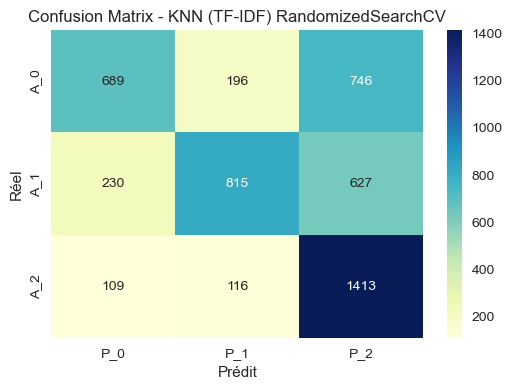


Classification Report – KNN (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.67      0.42      0.52      1631
           1       0.72      0.49      0.58      1672
           2       0.51      0.86      0.64      1638

    accuracy                           0.59      4941
   macro avg       0.63      0.59      0.58      4941
weighted avg       0.63      0.59      0.58      4941


Metrics – KNN (TF-IDF) RandomizedSearchCV
Model              KNN (TF-IDF) RandomizedSearchCV
AUC Score                                 0.693163
MCC                                       0.411852
Precision Score                           0.634088
Recall Score                              0.590366
f1-score                                  0.579898
Accuracy Score                            0.590366
Train Accuracy                            0.975001
CV                                        0.568139
dtype: object



In [ ]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

rs_knn = RandomizedSearchCV(
    KNeighborsClassifier(),
    param_dist_knn,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=6,
    verbose=1,
    random_state=42
)

rs_knn.fit(X_train_dense, y_train)
print("Best KNN params:", rs_knn.best_params_)

best_knn = rs_knn.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_knn,
    "KNN (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best SVC params: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100.0}


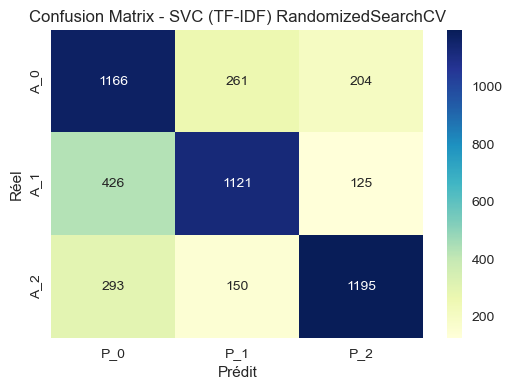


Classification Report – SVC (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1631
           1       0.73      0.67      0.70      1672
           2       0.78      0.73      0.76      1638

    accuracy                           0.70      4941
   macro avg       0.71      0.70      0.71      4941
weighted avg       0.71      0.70      0.71      4941



KeyboardInterrupt: 

In [ ]:
param_dist_svc = {
    'C': np.logspace(-3, 2, 10),
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

rs_svc = RandomizedSearchCV(
    SVC(max_iter=1000, random_state=42),
    param_dist_svc,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=6,
    verbose=1,
    random_state=42
)

rs_svc.fit(X_train_dense, y_train)
print("Best SVC params:", rs_svc.best_params_)

best_svc = rs_svc.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_svc,
    "SVC (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

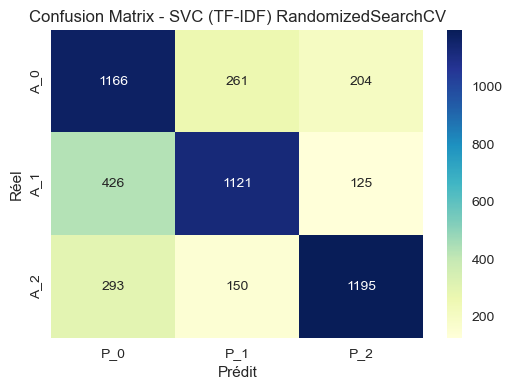


Classification Report – SVC (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      1631
           1       0.73      0.67      0.70      1672
           2       0.78      0.73      0.76      1638

    accuracy                           0.70      4941
   macro avg       0.71      0.70      0.71      4941
weighted avg       0.71      0.70      0.71      4941


Metrics – SVC (TF-IDF) RandomizedSearchCV
Model              SVC (TF-IDF) RandomizedSearchCV
AUC Score                                 0.778725
MCC                                       0.558894
Precision Score                           0.711742
Recall Score                              0.704716
f1-score                                  0.706301
Accuracy Score                            0.704716
Train Accuracy                            0.795557
CV                                        0.722509
dtype: object



In [ ]:
result_tabulation_rse = Model_Evaluation1(
    best_svc,
    "SVC (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Random Forest params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'bootstrap': True}


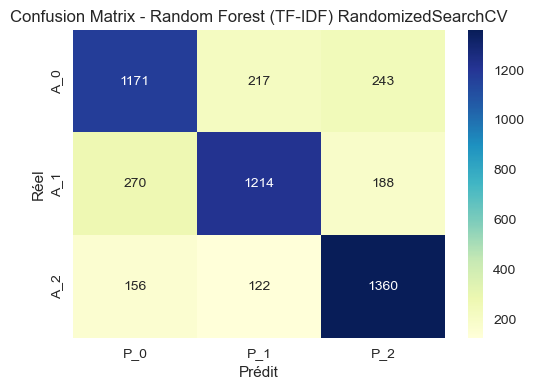


Classification Report – Random Forest (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.73      0.72      0.73      1631
           1       0.78      0.73      0.75      1672
           2       0.76      0.83      0.79      1638

    accuracy                           0.76      4941
   macro avg       0.76      0.76      0.76      4941
weighted avg       0.76      0.76      0.76      4941


Metrics – Random Forest (TF-IDF) RandomizedSearchCV
Model              Random Forest (TF-IDF) RandomizedSearchCV
AUC Score                                           0.818572
MCC                                                 0.637738
Precision Score                                     0.758303
Recall Score                                        0.757944
f1-score                                            0.757225
Accuracy Score                                      0.757944
Train Accuracy                                      0.846921
CV        

In [ ]:
param_dist_rf = {
    'n_estimators': [100, 500, 300],
    'max_depth': [None, 10, 20, 50],
    'min_samples_split': [2, 1, 10],
    'min_samples_leaf': [6, 2, 4],
    'bootstrap': [True, False]
}

rs_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_dist_rf,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=6,
    verbose=1,
    random_state=42
)

rs_rf.fit(X_train_dense, y_train)
print("Best Random Forest params:", rs_rf.best_params_)

best_rf = rs_rf.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_rf,
    "Random Forest (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best AdaBoost params: {'n_estimators': 200, 'learning_rate': 1.0}


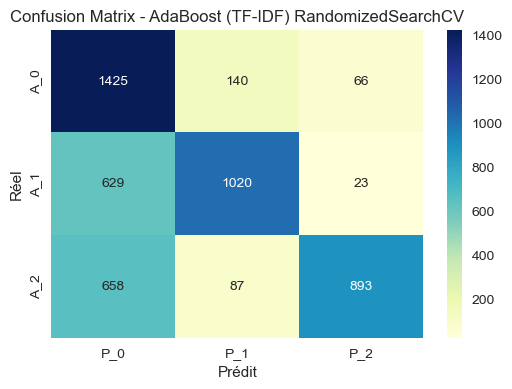


Classification Report – AdaBoost (TF-IDF) RandomizedSearchCV

              precision    recall  f1-score   support

           0       0.53      0.87      0.66      1631
           1       0.82      0.61      0.70      1672
           2       0.91      0.55      0.68      1638

    accuracy                           0.68      4941
   macro avg       0.75      0.68      0.68      4941
weighted avg       0.75      0.68      0.68      4941


Metrics – AdaBoost (TF-IDF) RandomizedSearchCV
Model              AdaBoost (TF-IDF) RandomizedSearchCV
AUC Score                                      0.757286
MCC                                            0.544534
Precision Score                                0.751705
Recall Score                                   0.675572
f1-score                                       0.679095
Accuracy Score                                 0.675572
Train Accuracy                                 0.687718
CV                                             0.672663
dtyp

In [ ]:
param_dist_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0, 2.0]
}

rs_ab = RandomizedSearchCV(
    AdaBoostClassifier(random_state=42),
    param_dist_ab,
    n_iter=10,
    scoring='accuracy',
    cv=5,
    n_jobs=6,
    verbose=1,
    random_state=42
)

rs_ab.fit(X_train_dense, y_train)
print("Best AdaBoost params:", rs_ab.best_params_)

best_ab = rs_ab.best_estimator_

result_tabulation_rse = Model_Evaluation1(
    best_ab,
    "AdaBoost (TF-IDF) RandomizedSearchCV",
    X_train_dense, y_train,
    X_test_dense, y_test,
    result_tabulation_rse
)

In [ ]:
result_tabulation_rse

,Model,AUC Score,MCC,Precision Score,Recall Score,f1-score,Accuracy Score,Train Accuracy,CV
0,Logistic Regression (BERT) RandomizedSearchCV,0.795286,0.5908,0.727174,0.726978,0.726722,0.726978,0.76398,0.726633
1,Logistic Regression (TF-IDF) RandomizedSearchCV,0.861337,0.722809,0.81498,0.815017,0.814705,0.815017,0.906331,0.804615
2,Decision Tree (TF-IDF) RandomizedSearchCV,0.768919,0.538866,0.692067,0.691763,0.690471,0.691763,0.816406,0.672967
3,KNN (TF-IDF) RandomizedSearchCV,0.693163,0.411852,0.634088,0.590366,0.579898,0.590366,0.975001,0.568139
4,SVC (TF-IDF) RandomizedSearchCV,0.778725,0.558894,0.711742,0.704716,0.706301,0.704716,0.795557,0.722509
5,Random Forest (TF-IDF) RandomizedSearchCV,0.818572,0.637738,0.758303,0.757944,0.757225,0.757944,0.846921,0.746546
6,AdaBoost (TF-IDF) RandomizedSearchCV,0.757286,0.544534,0.751705,0.675572,0.679095,0.675572,0.687718,0.672663
7,SVC (BERT) RandomizedSearchCV,0.809121,0.619151,0.748622,0.745193,0.745387,0.745193,0.841304,0.741916


In [ ]:
import pickle

# Sauvegarde
with open('best_lr_model.pkl', 'wb') as f:
    pickle.dump(best_lr, f)

# Chargement
with open('best_lr_model.pkl', 'rb') as f:
    best_lr = pickle.load(f)

In [ ]:
from joblib import dump

# Sauvegarde du modèle TF-IDF
dump(best_lr, 'logreg_tfidf_model.joblib', compress=3)


['logreg_tfidf_model.joblib']